In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
# from shapely.geometry import Point
# import cartopy.feature as cfeature
# import cartopy.crs as ccrs
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

In [105]:
PATH_TEST = Path('Z:/nahaUsers/casadje/Guadiana/')
# PATH_GLOFAS4 = Path('Z:/nahaUsers/casadje/GloFASv4')
PATH_TS = Path('Z:/nahaUsers/casadje/datasets/hDMS/river')

### Stations

In [3]:
stations = gpd.read_file(PATH_TEST / 'GIS' / 'river_HDMS_20250314.shp').set_index('EFAS_ID')
# stations.head()

In [102]:
stations.START

EFAS_ID
328            None
1424           None
1443           None
1444           None
1445           None
            ...    
10284    20-02-2025
10285    20-02-2025
10286    01/09/2023
10287    01/01/2022
10288          None
Name: START, Length: 104, dtype: object

In [104]:
stations.END

EFAS_ID
328      None
1424     None
1443     None
1444     None
1445     None
         ... 
10284    None
10285    None
10286    None
10287    None
10288    None
Name: END, Length: 104, dtype: object

### Time series

In [168]:
services = {
    'HIST': 'nhoperational24hw',
    'NRT': 'noperational24h'
}

timeseries = {}
for efas_id in stations.index:
    ls = []
    for name, service in services.items():
        file_name = PATH_TS / service / f'{efas_id}.nc'
        if file_name.is_file():
            df = xr.open_dataset(file_name, engine='netcdf4')['discharge'].to_pandas()
            df.columns = [name]
            ls.append(df)
    if len(ls) > 0:
        ts = pd.concat(ls, axis=1)
        aux = pd.DataFrame(index=pd.date_range(ts.index[0], ts.index[-1], freq='d'), columns=ts.columns)
        aux.loc[ts.index, :] = ts.values
        timeseries[efas_id] = aux
    else:
        print(f'Station {efas_id} has no data')

Station 2118 has no data
Station 2119 has no data
Station 10286 has no data
Station 10287 has no data
Station 10288 has no data


In [176]:
stations.START

EFAS_ID
328      2016-05-21 00:00:00
1424                    None
1443                    None
1444                    None
1445                    None
                ...         
10284    2022-01-01 00:00:00
10285    2022-02-01 00:00:00
10286             01/09/2023
10287             01/01/2022
10288                   None
Name: START, Length: 104, dtype: object

In [183]:
stations[['START', 'END']] = np.nan
stations[['START', 'END']] = stations[['START', 'END']].apply(pd.to_datetime)
for efas_id, ts in timeseries.items():
    stations.loc[efas_id, ['START', 'END']] = ts.first_valid_index(), ts.last_valid_index()

In [192]:
mask_duration = (stations.END - stations.START).dt.days > 4 * 36

In [195]:
stations_sel = stations[mask_duration]

In [196]:
stations_sel.RIVER_EN.value_counts()

guadiana                19
ciguela/giguela          4
zujar                    4
ruecas                   3
zancara                  3
                        ..
esteras                  1
guadalemar               1
siruela/agudo            1
alcollarin               1
rivera de la albuera     1
Name: RIVER_EN, Length: 61, dtype: int64

C:\Users\casadje\AppData\Local\Temp\ipykernel_16844\1103511071.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(16, 4))


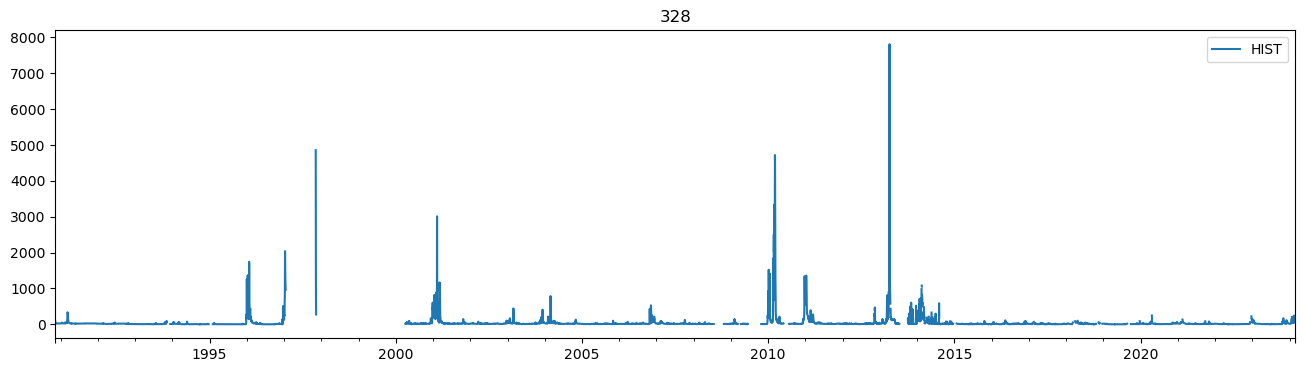

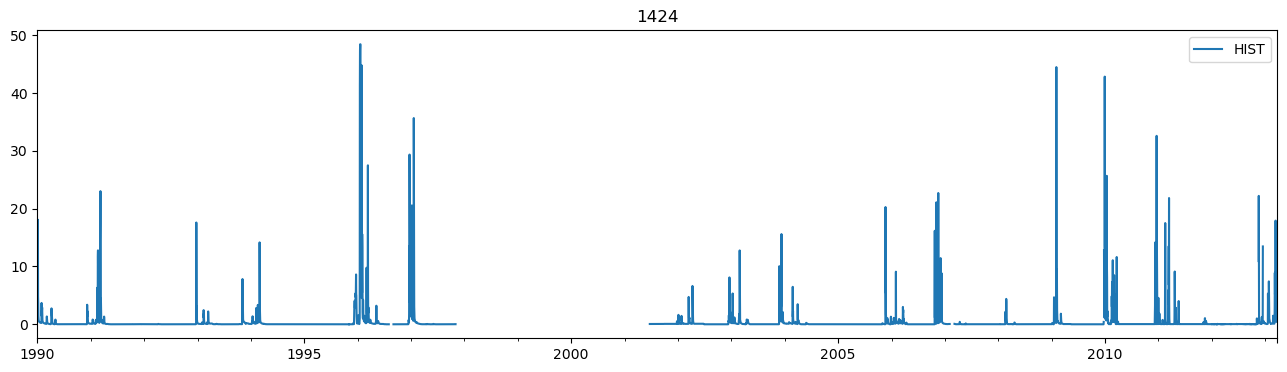

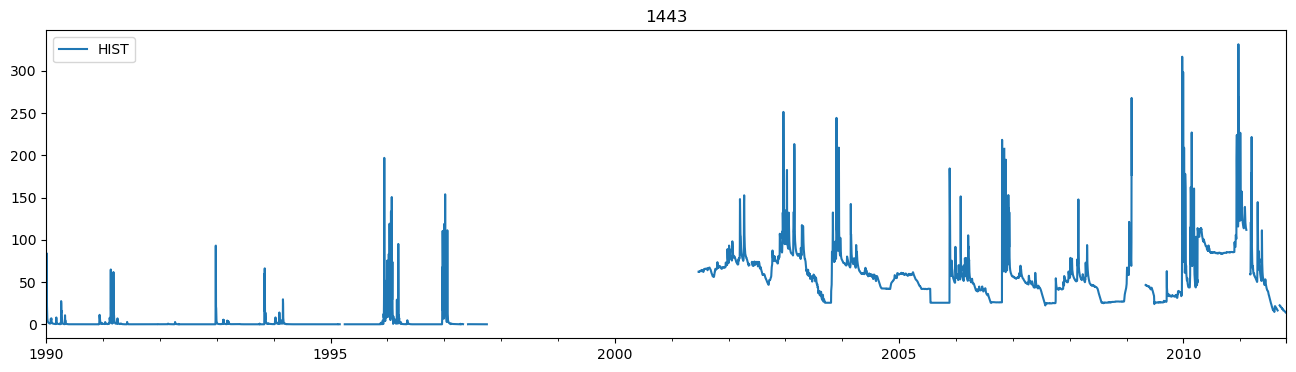

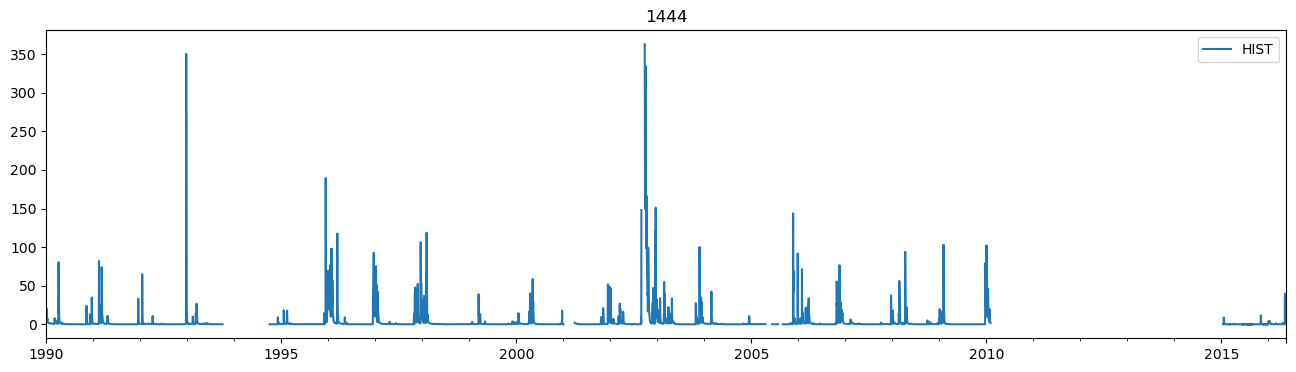

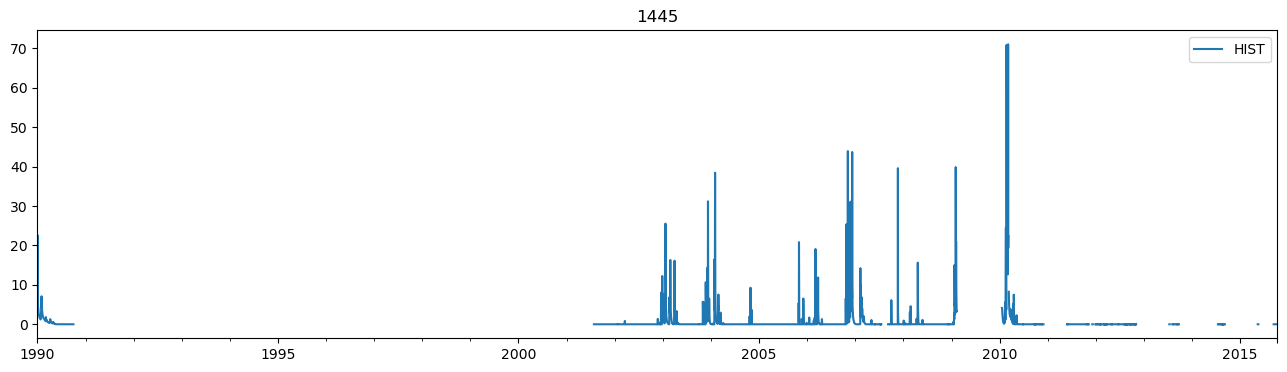

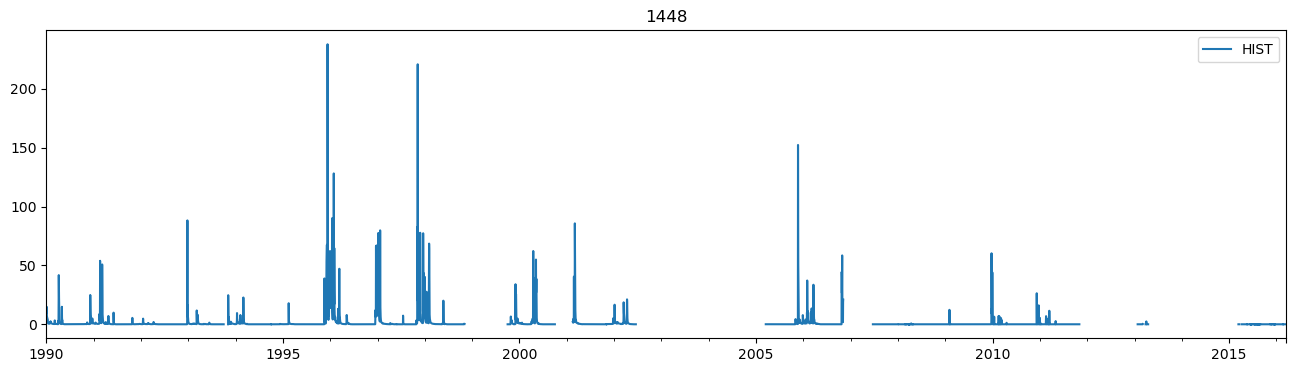

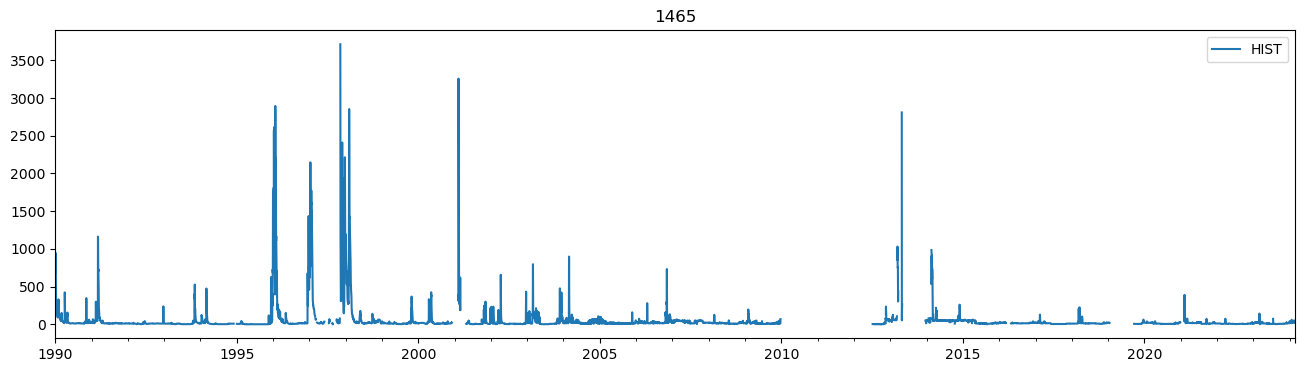

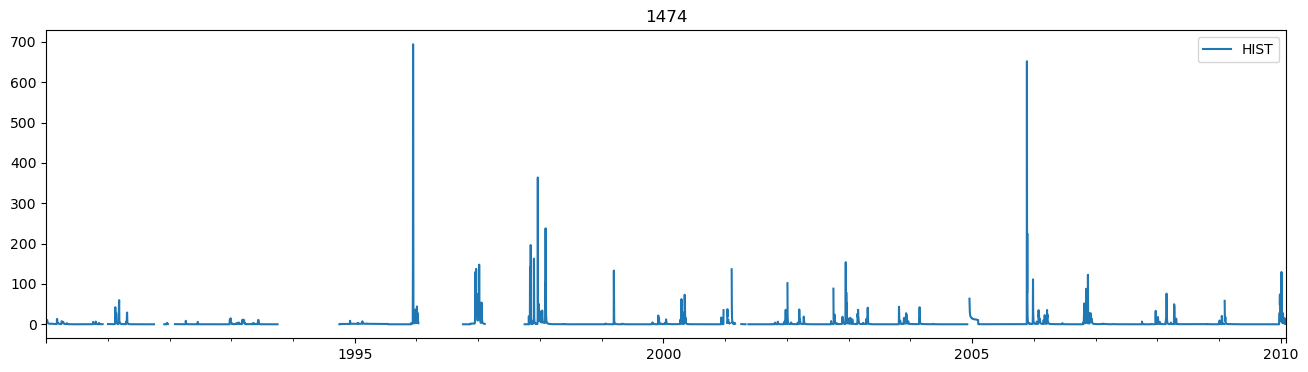

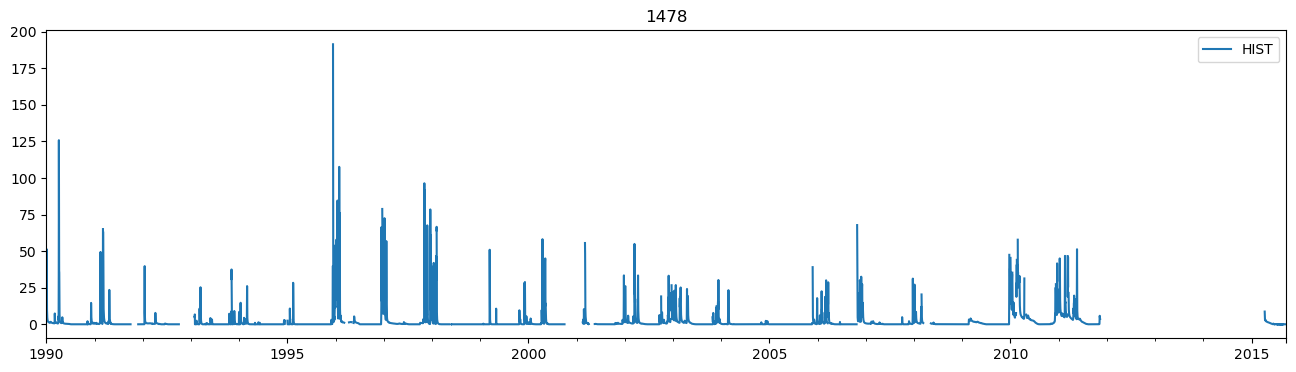

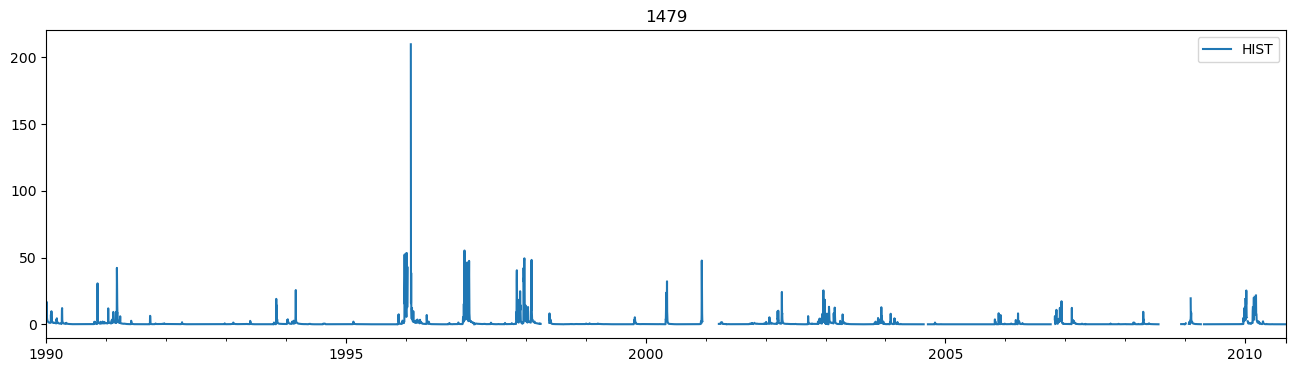

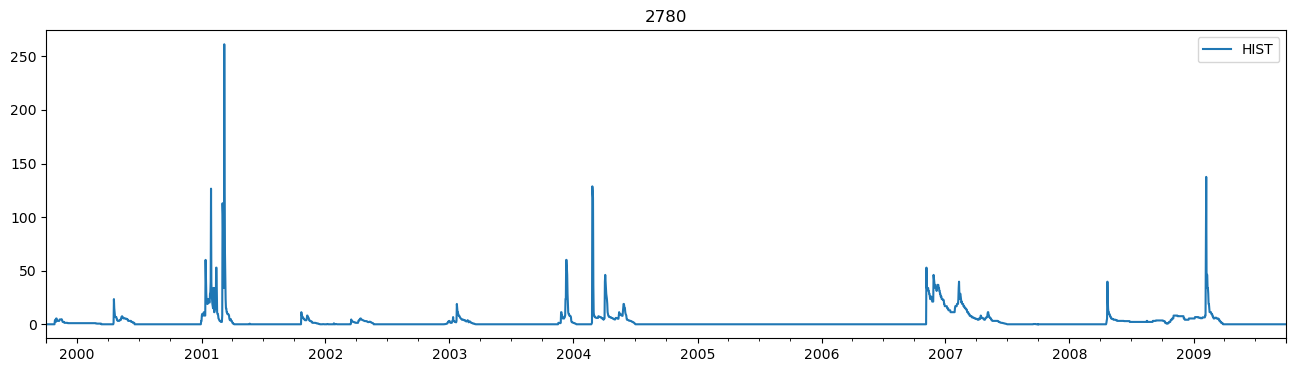

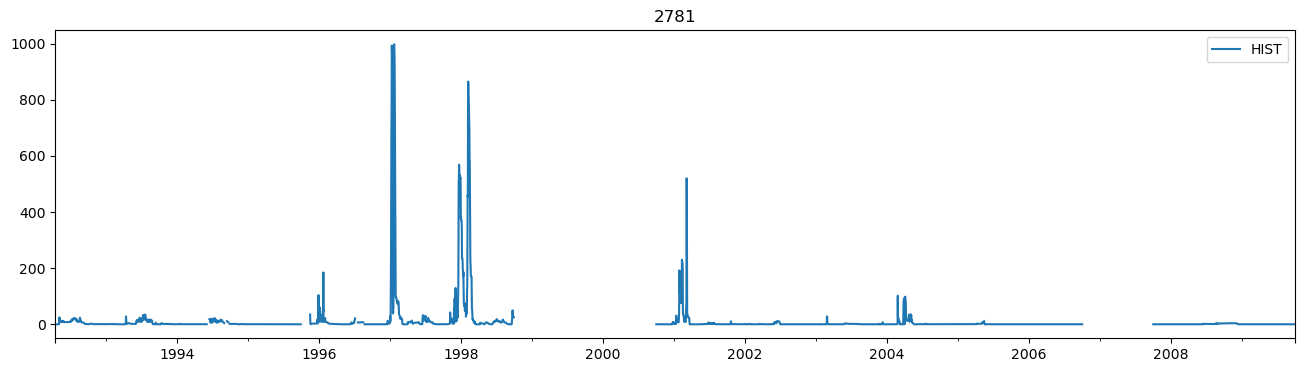

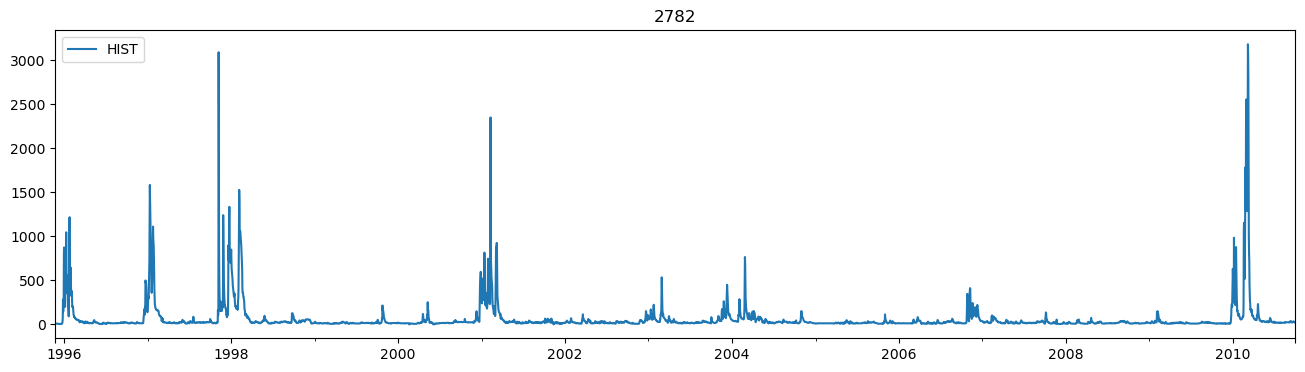

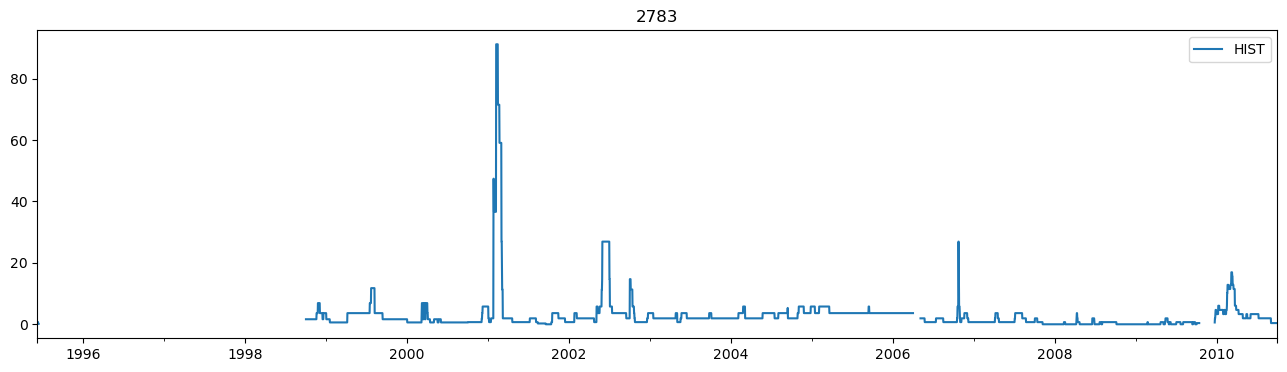

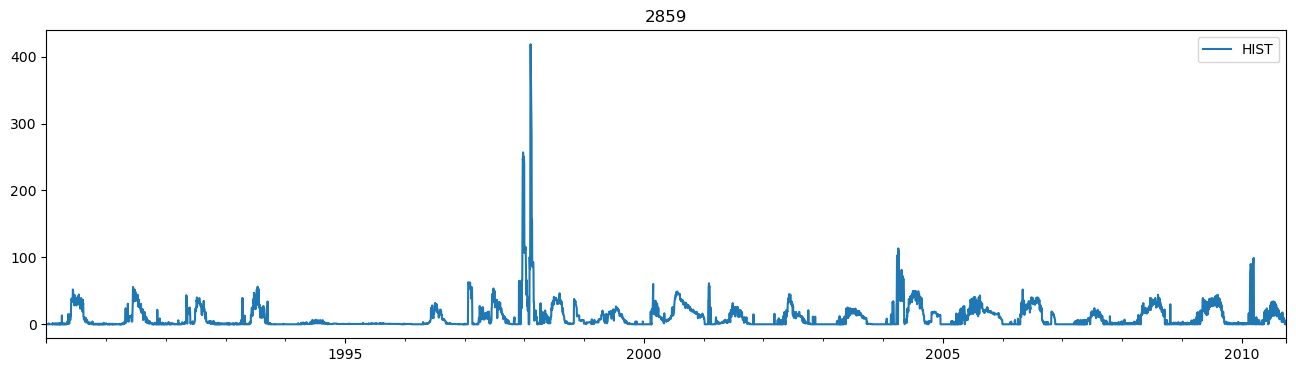

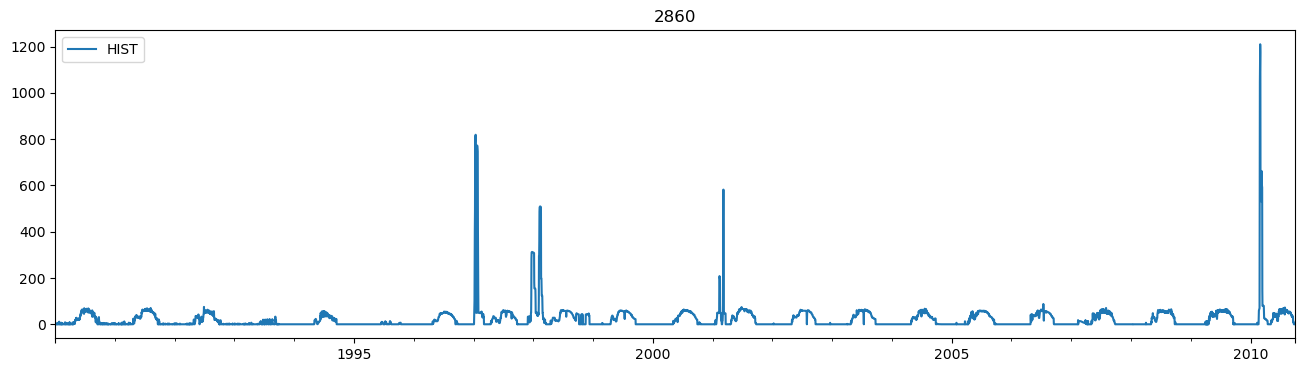

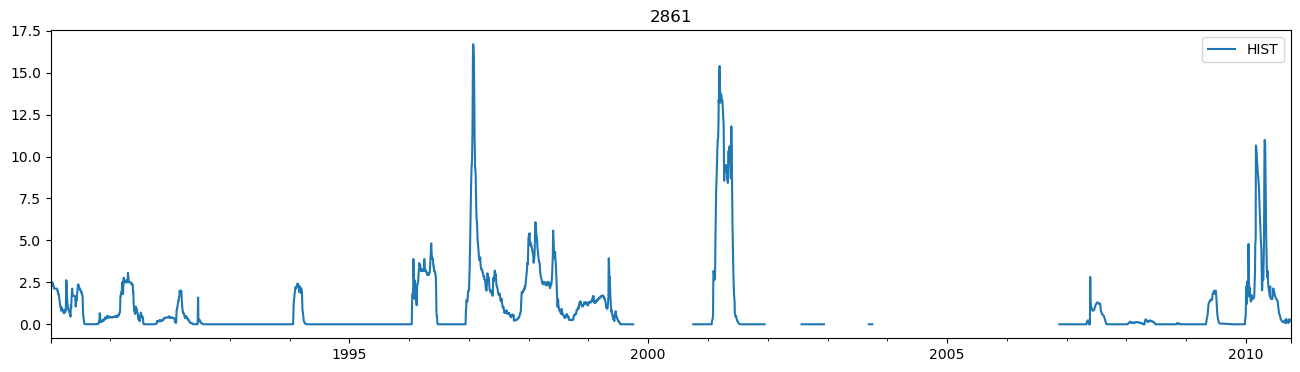

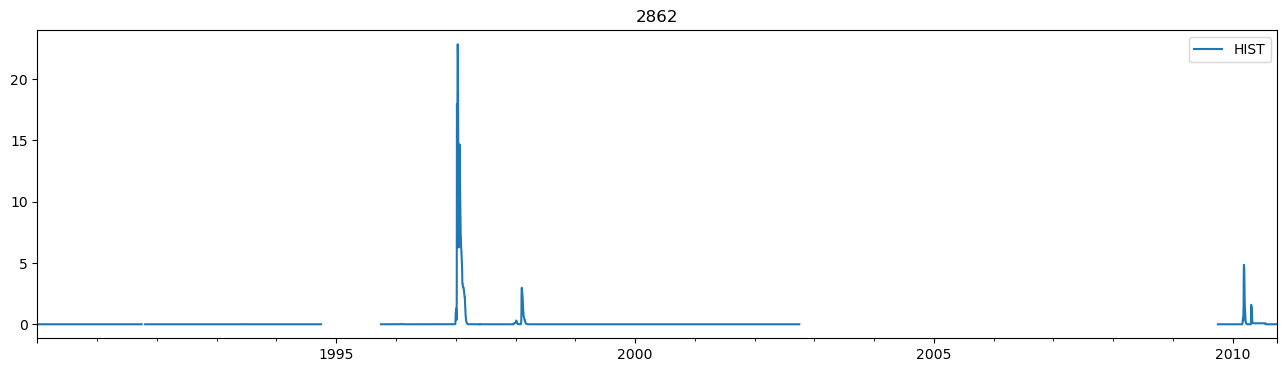

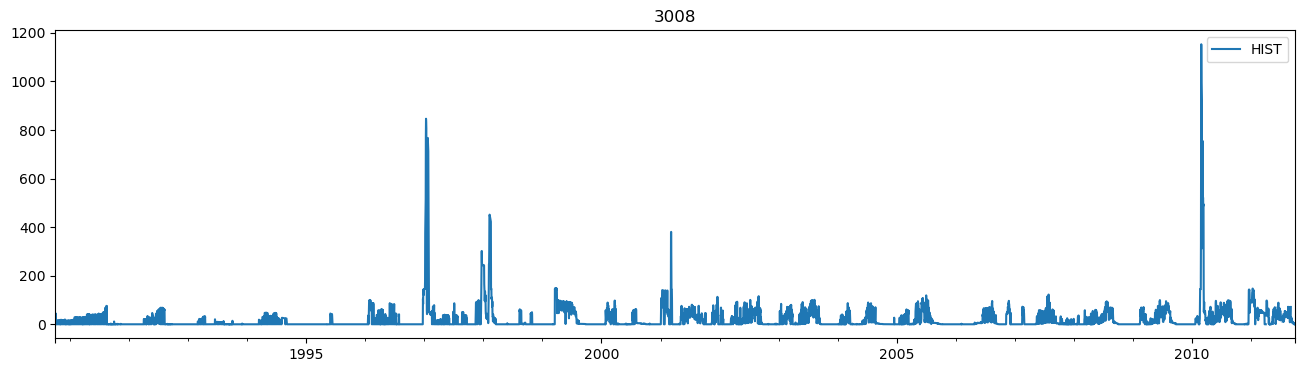

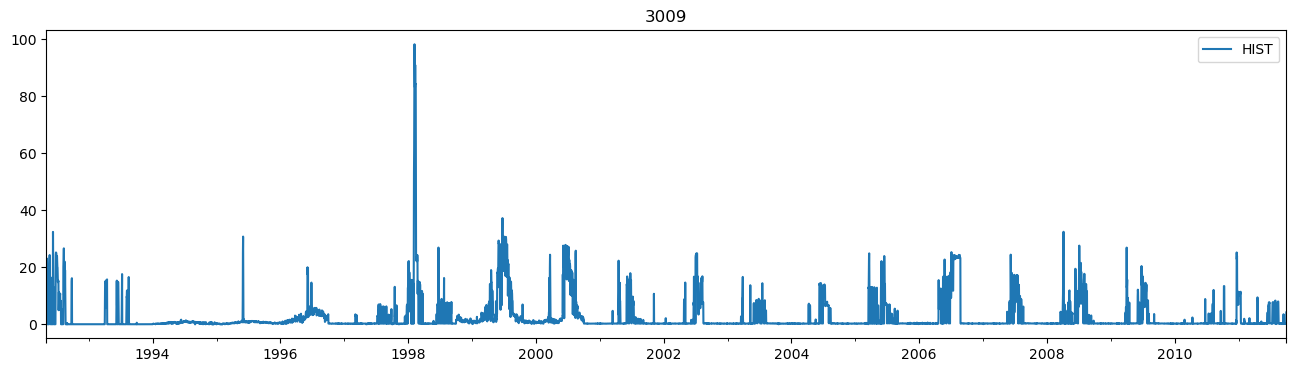

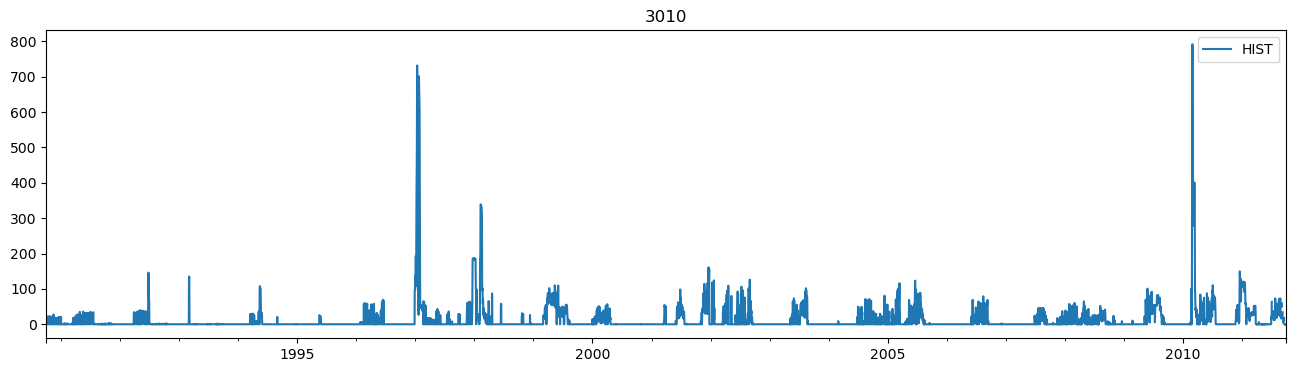

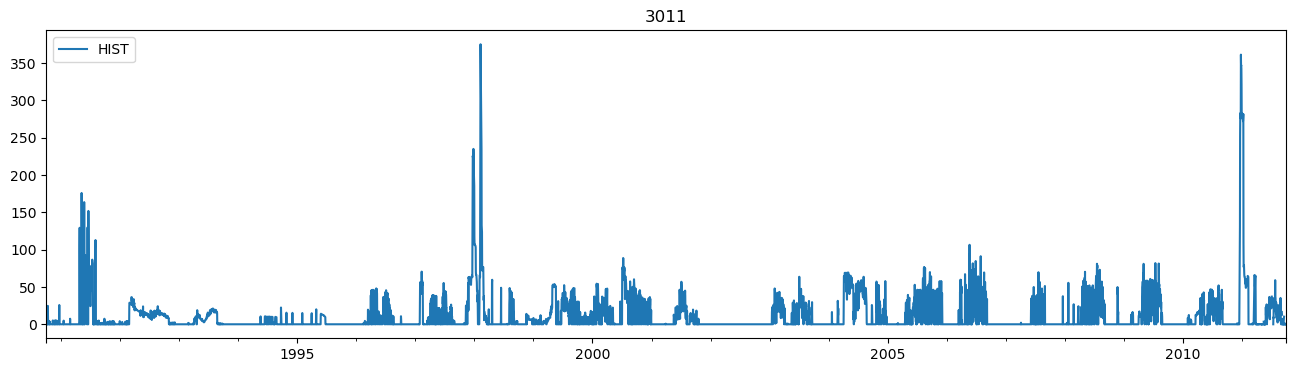

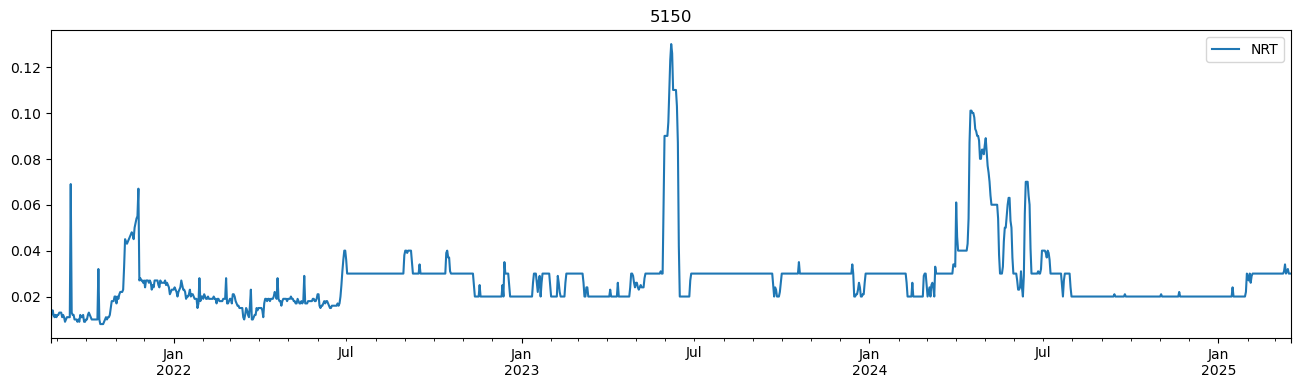

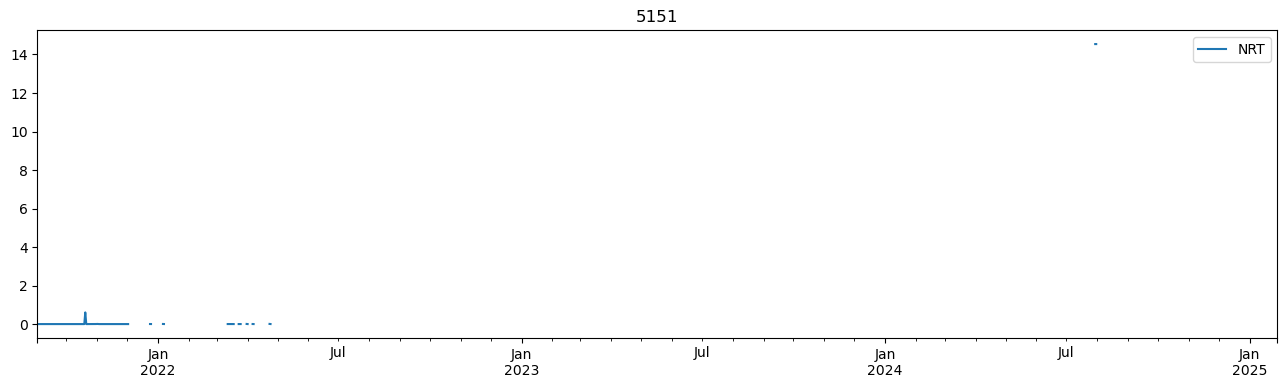

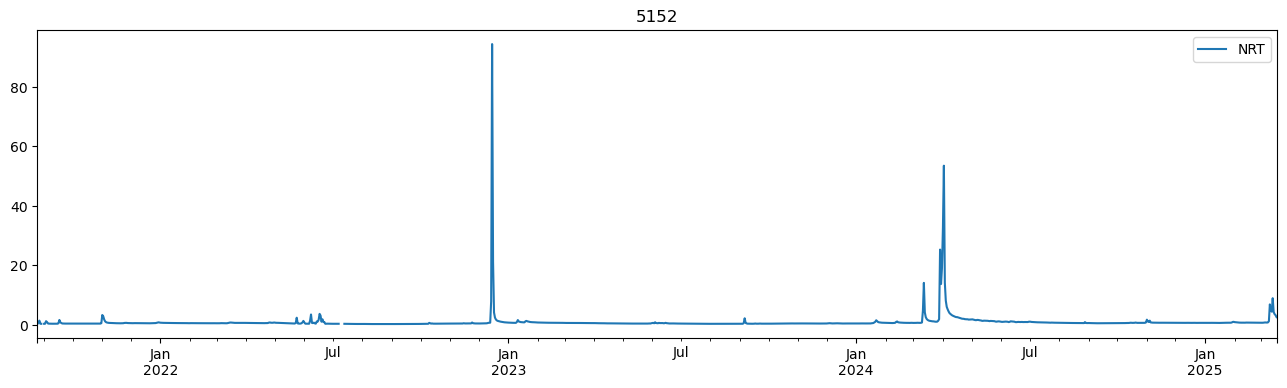

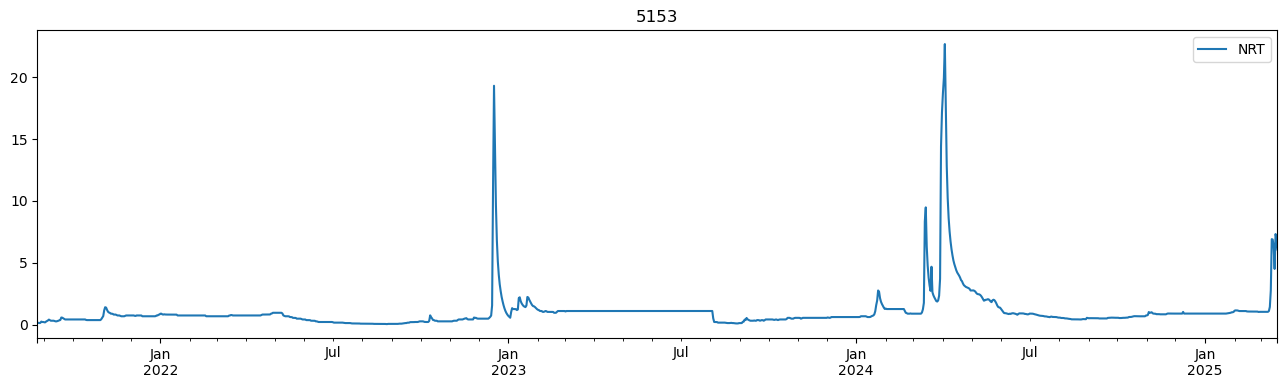

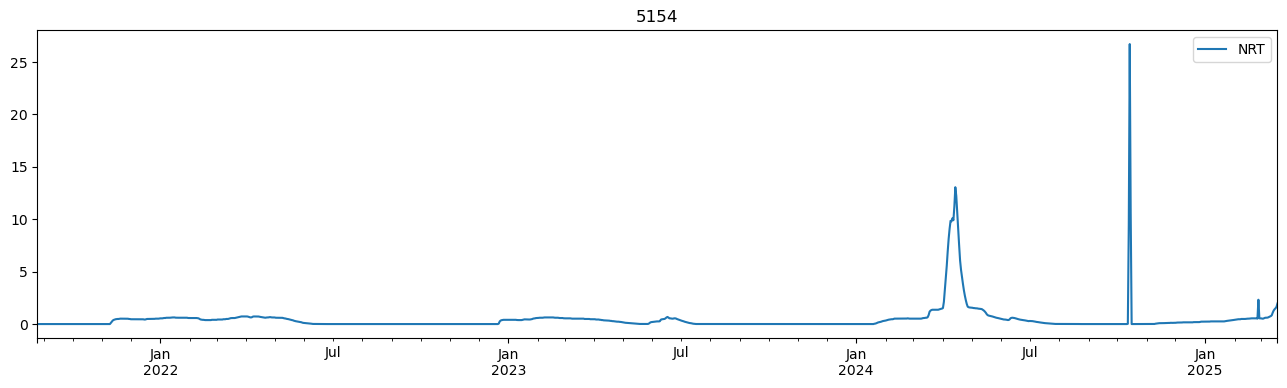

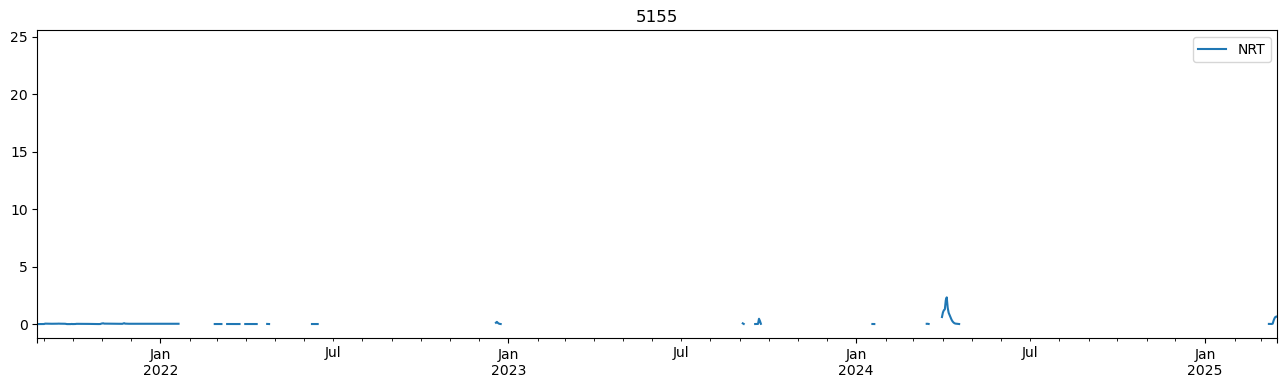

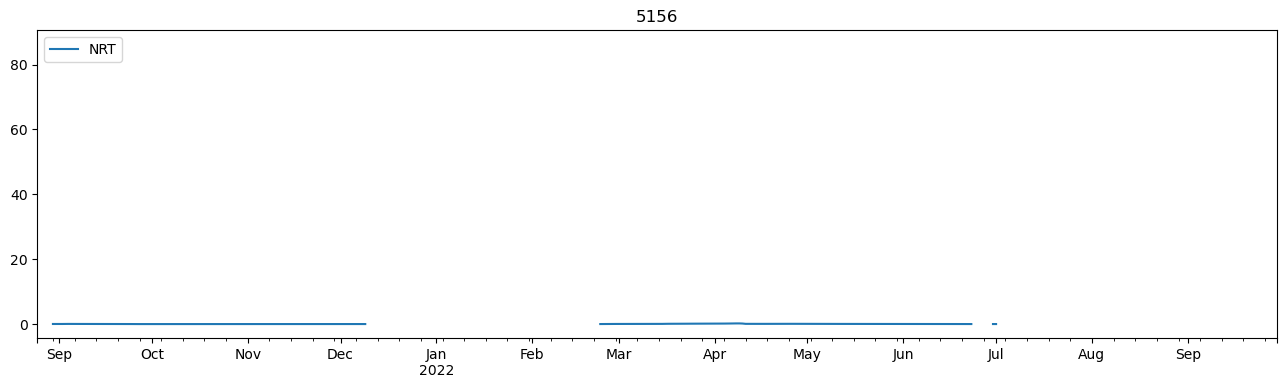

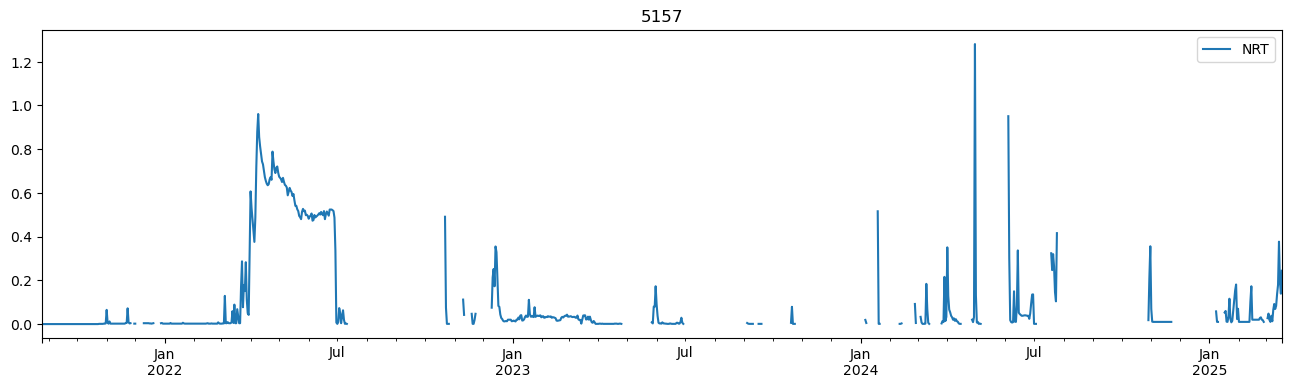

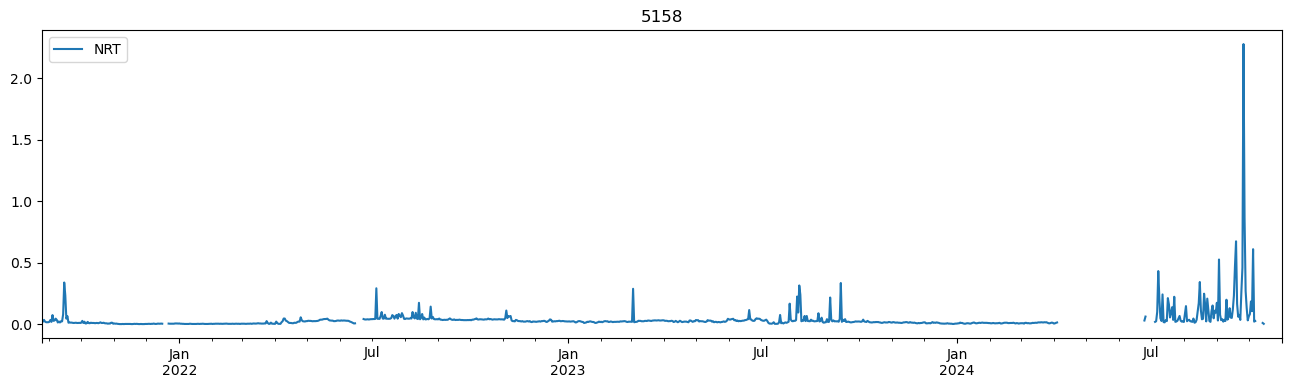

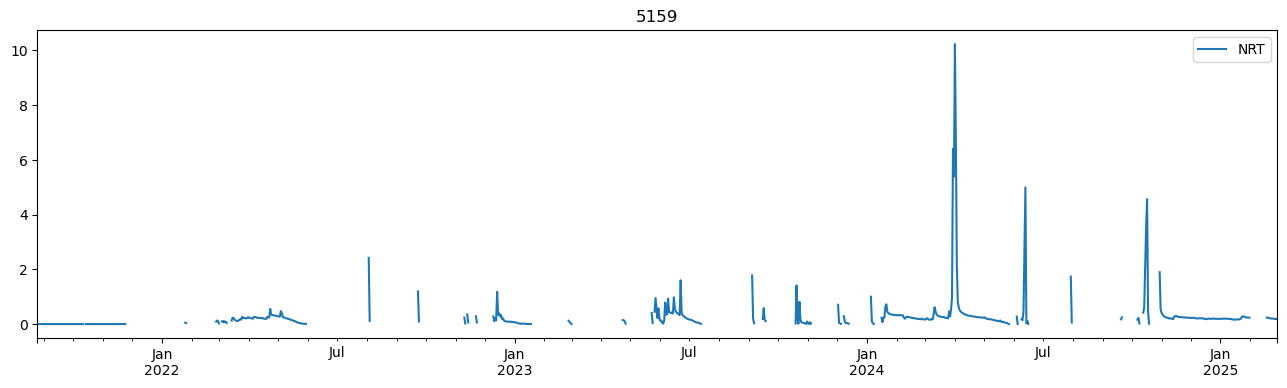

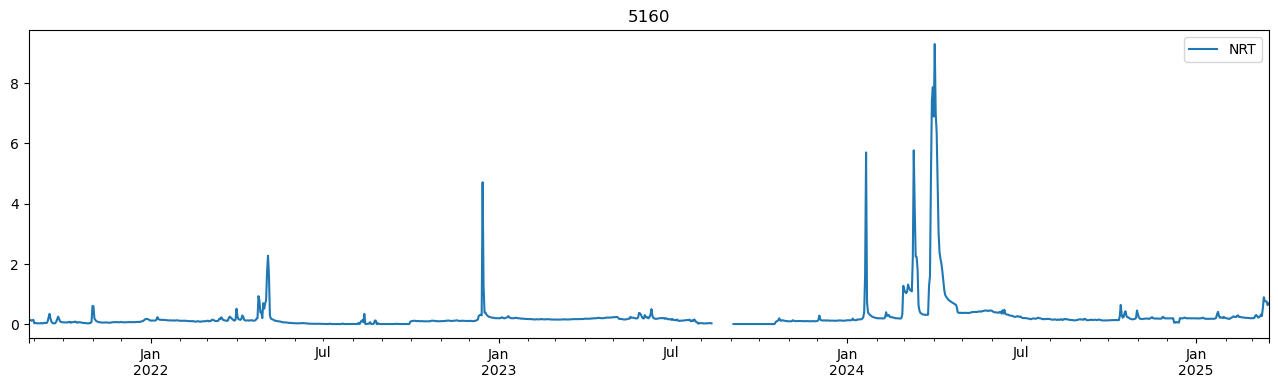

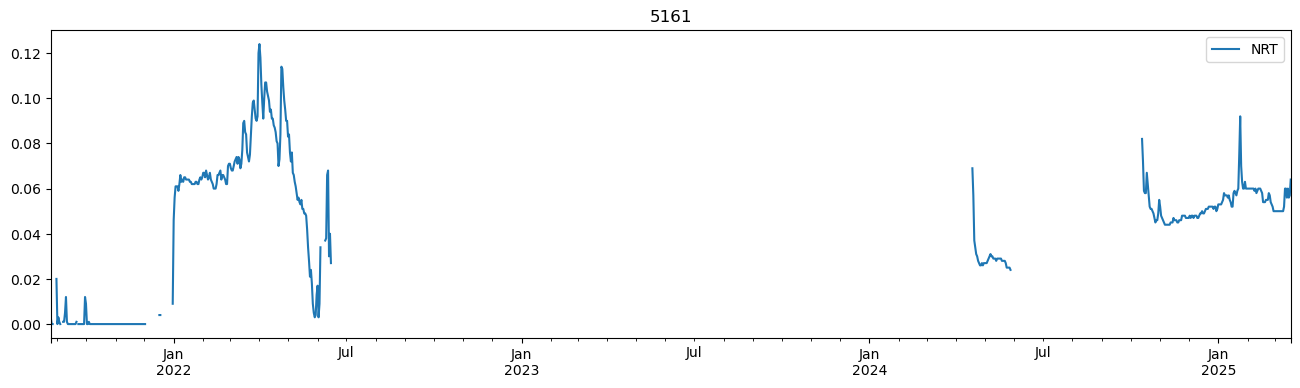

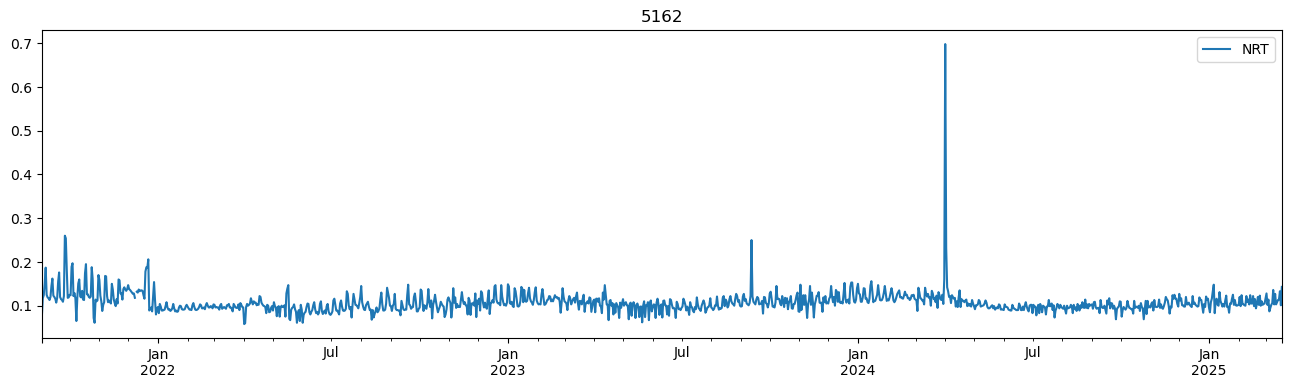

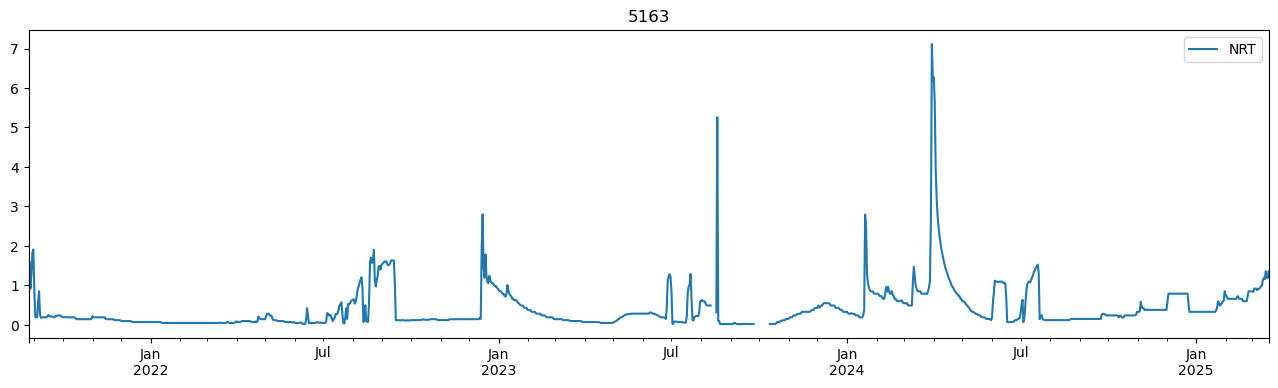

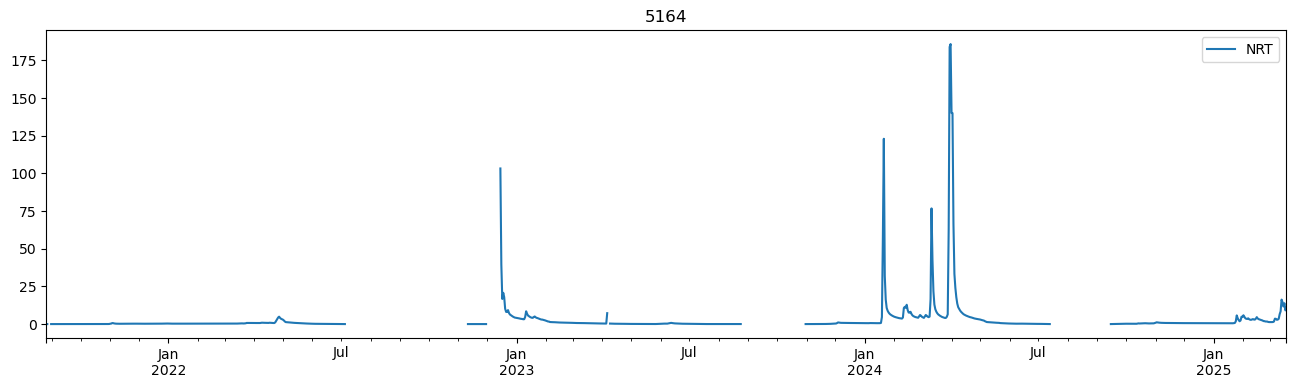

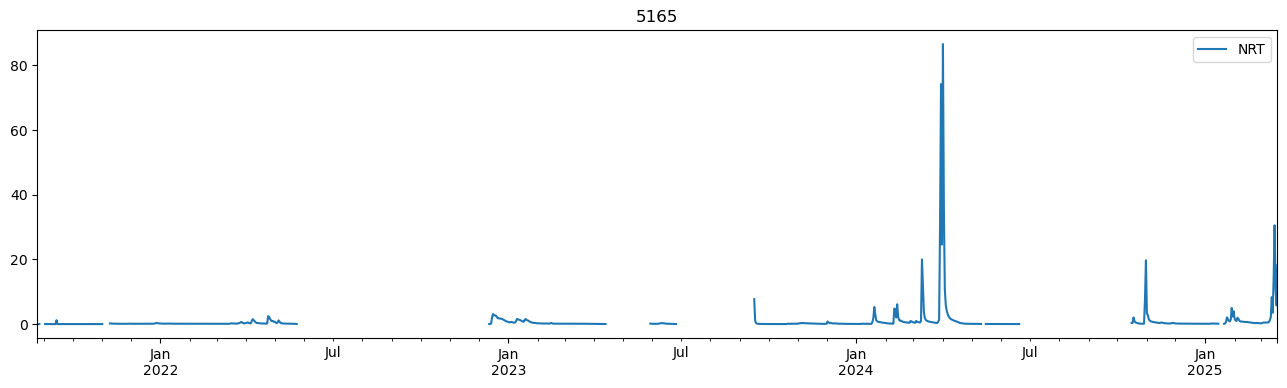

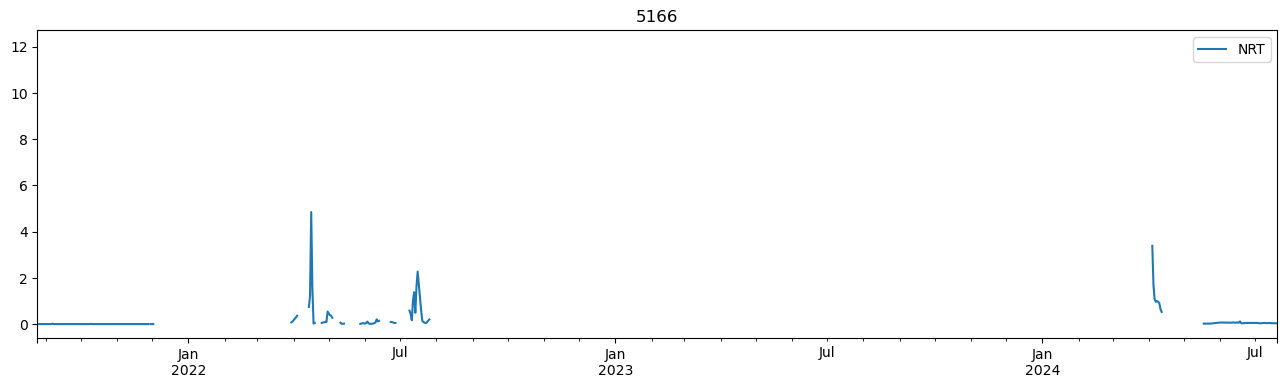

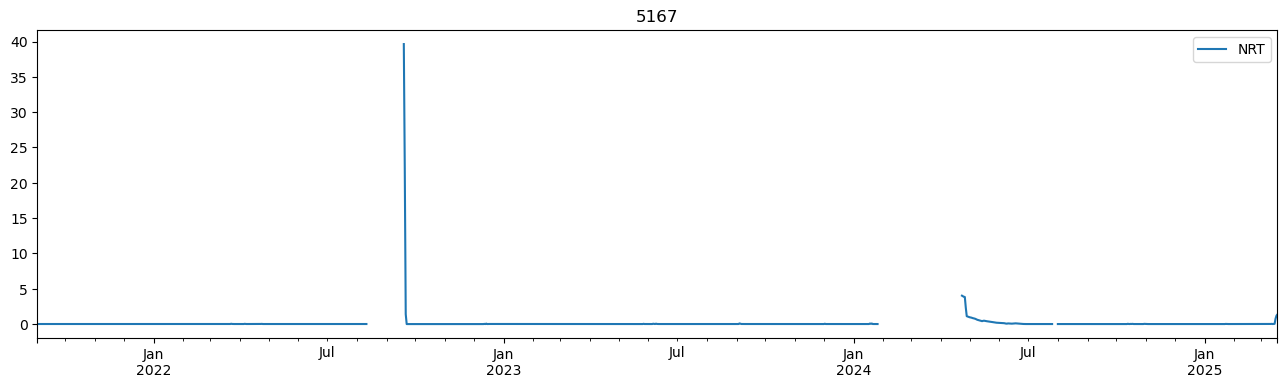

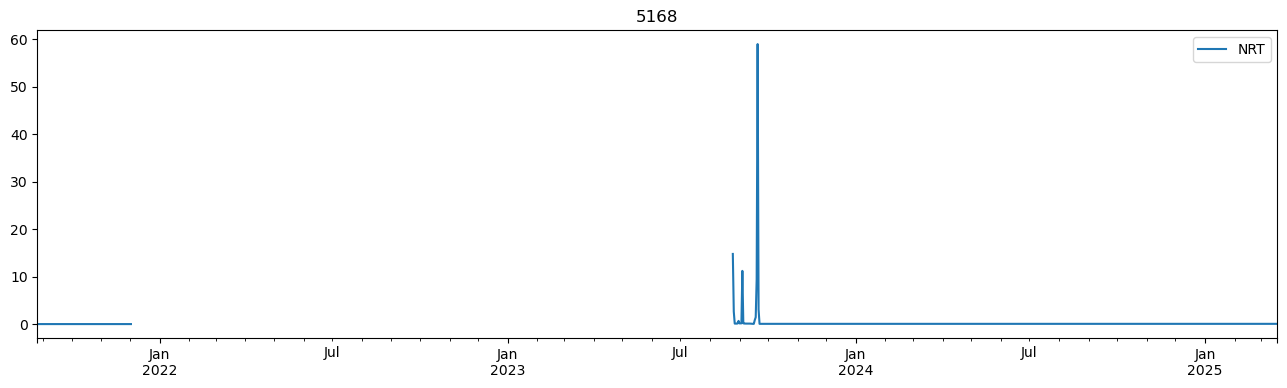

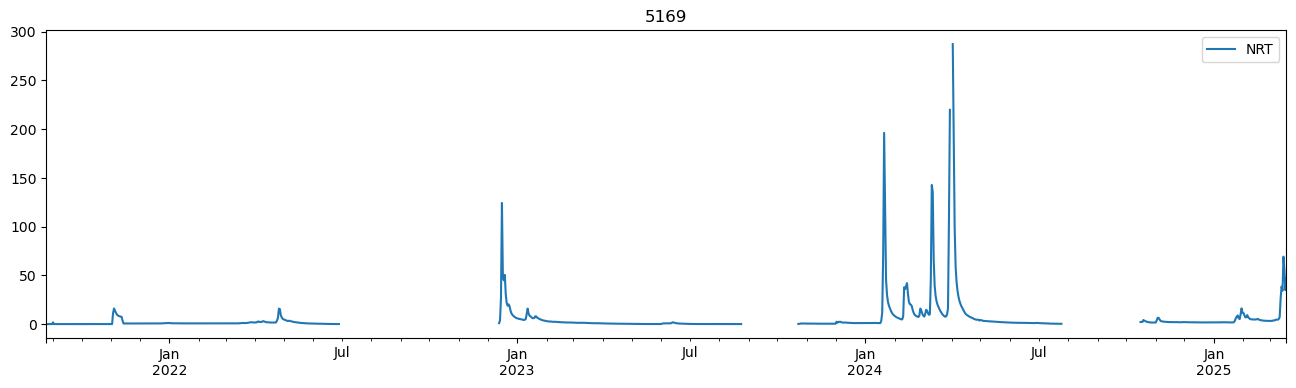

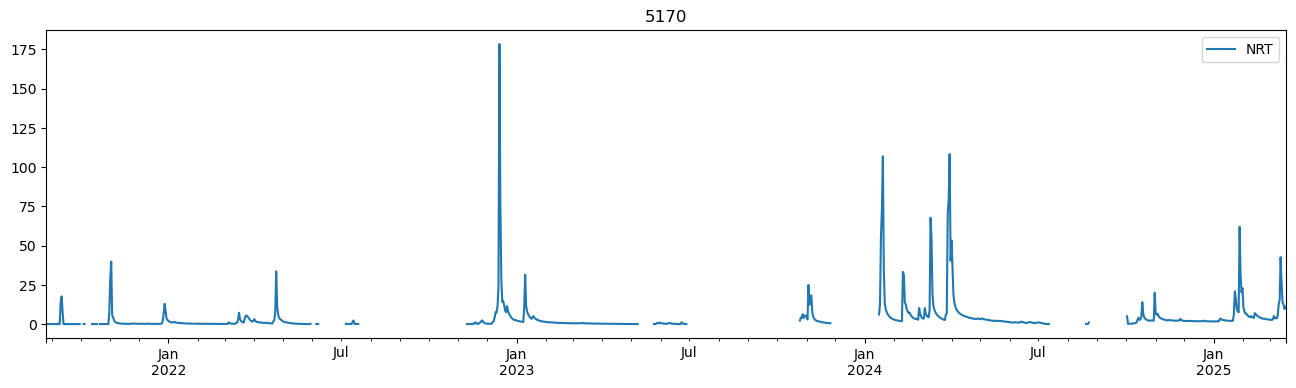

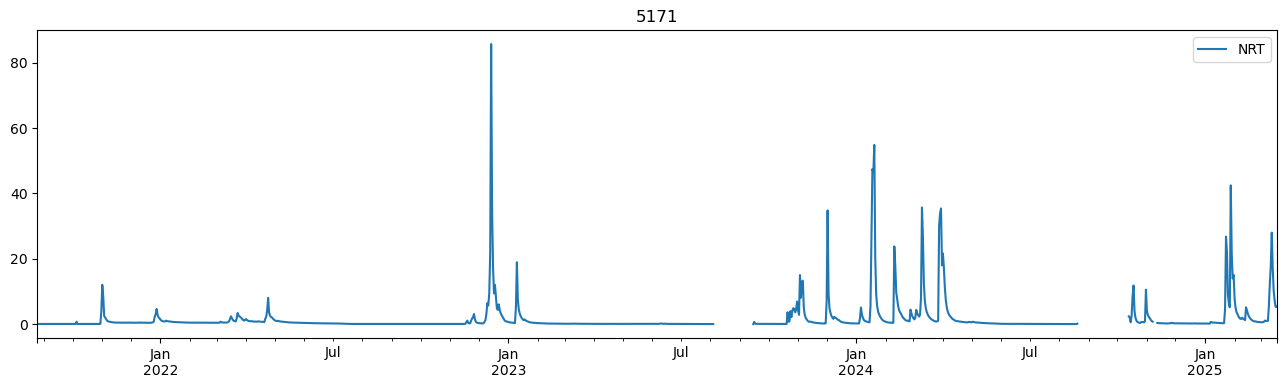

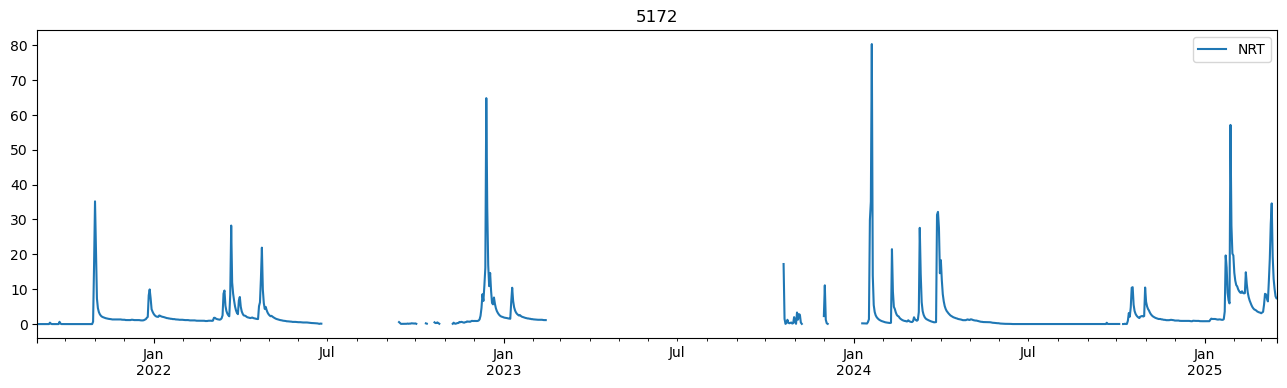

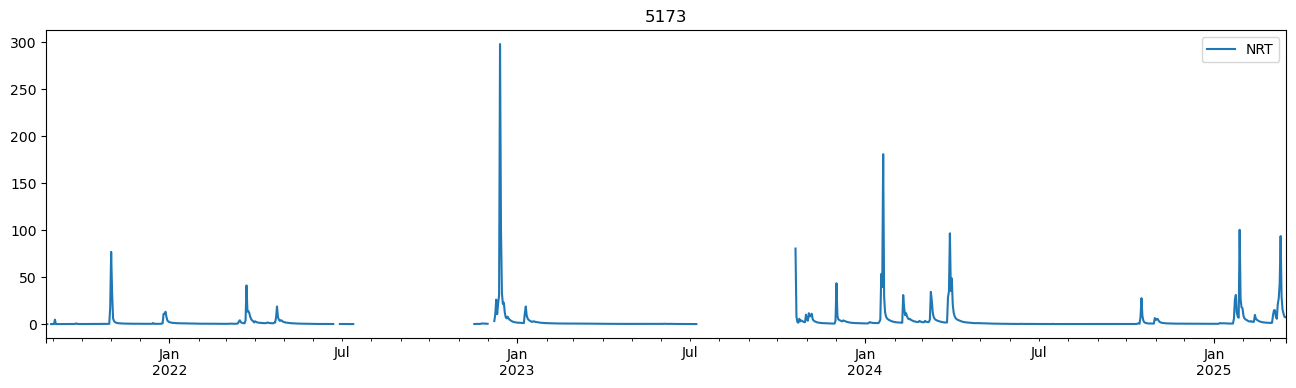

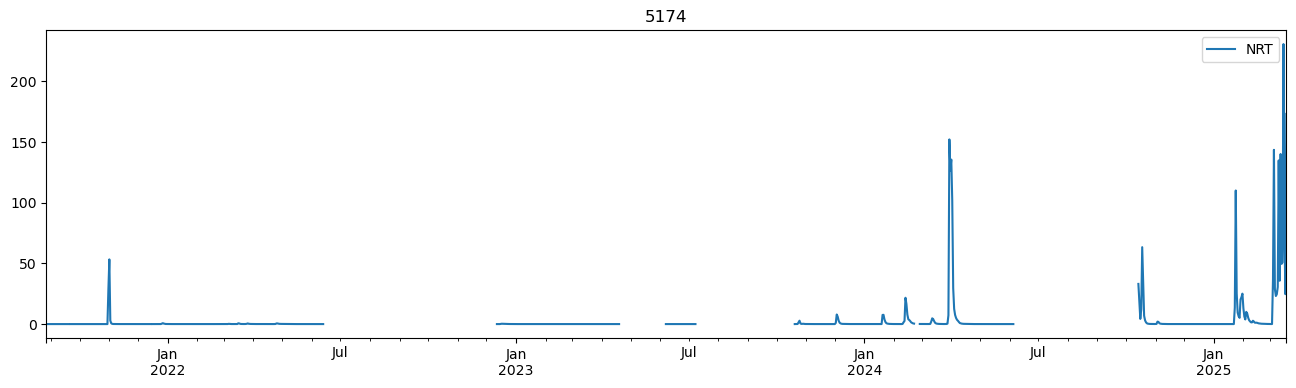

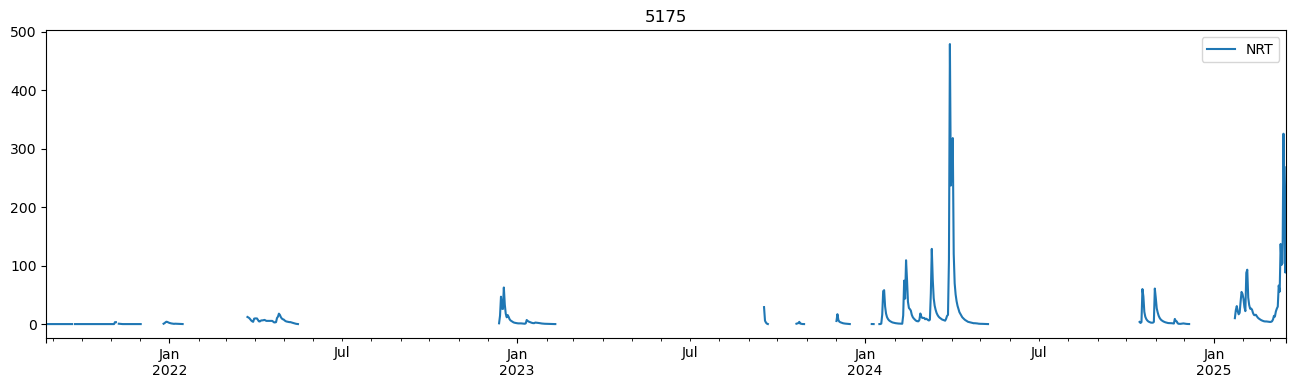

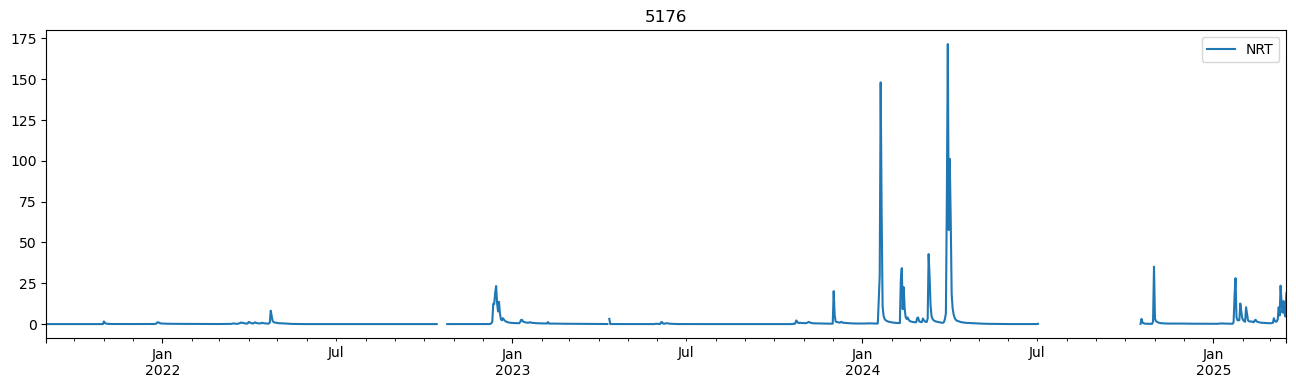

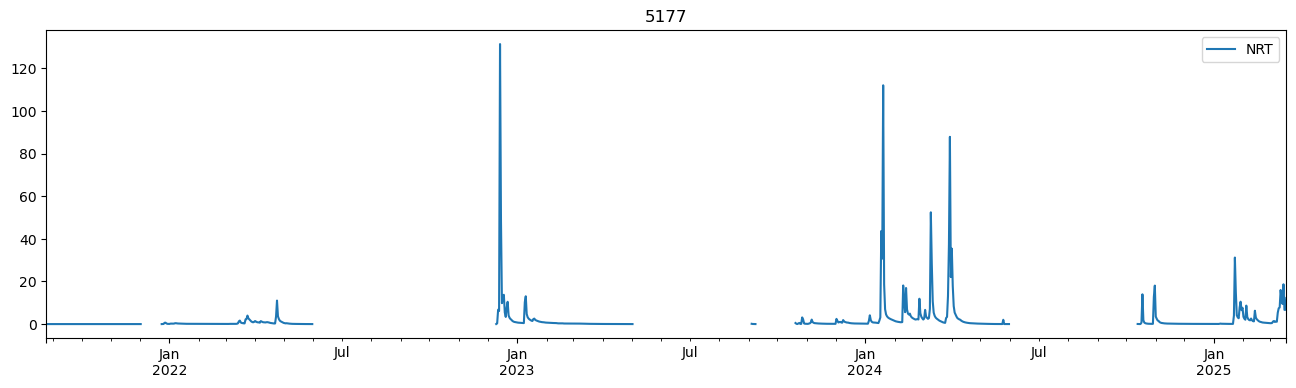

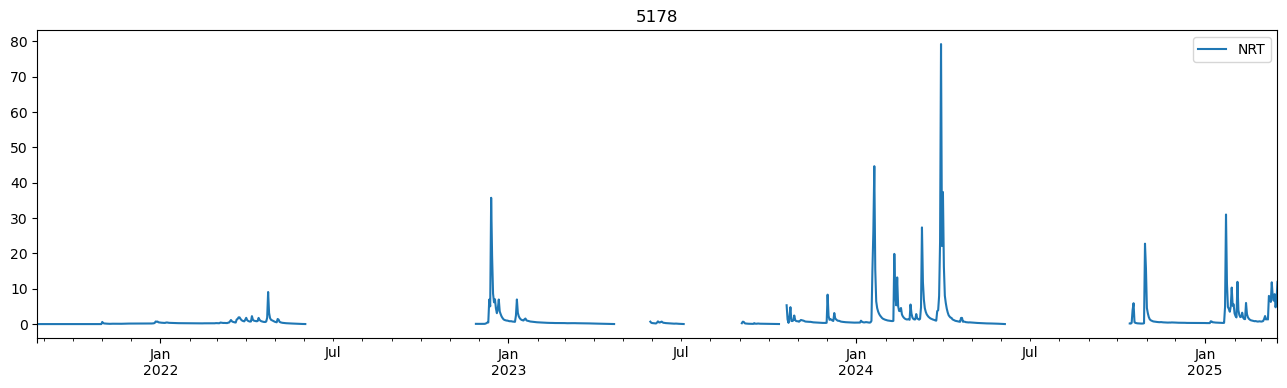

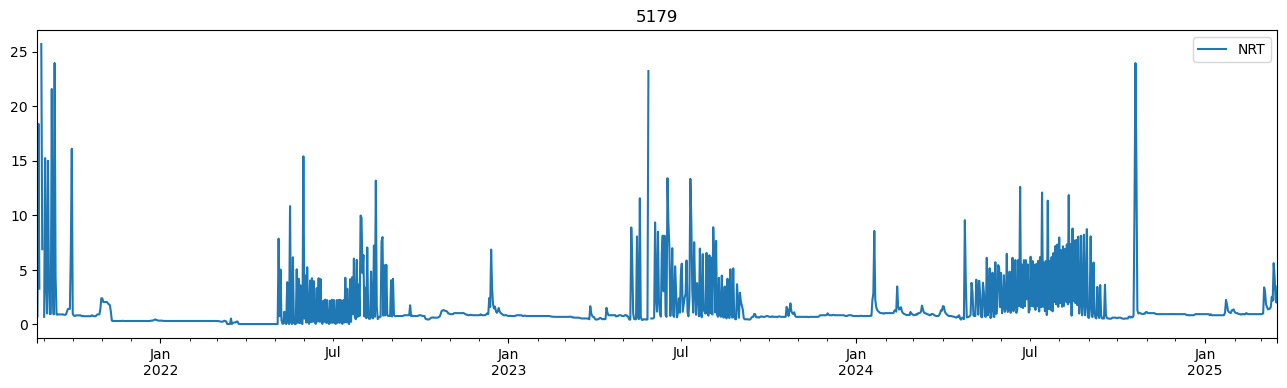

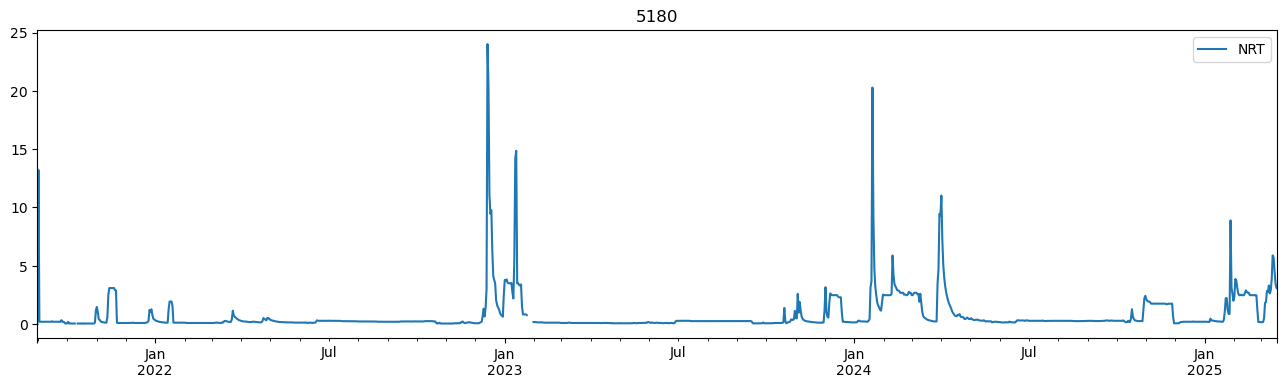

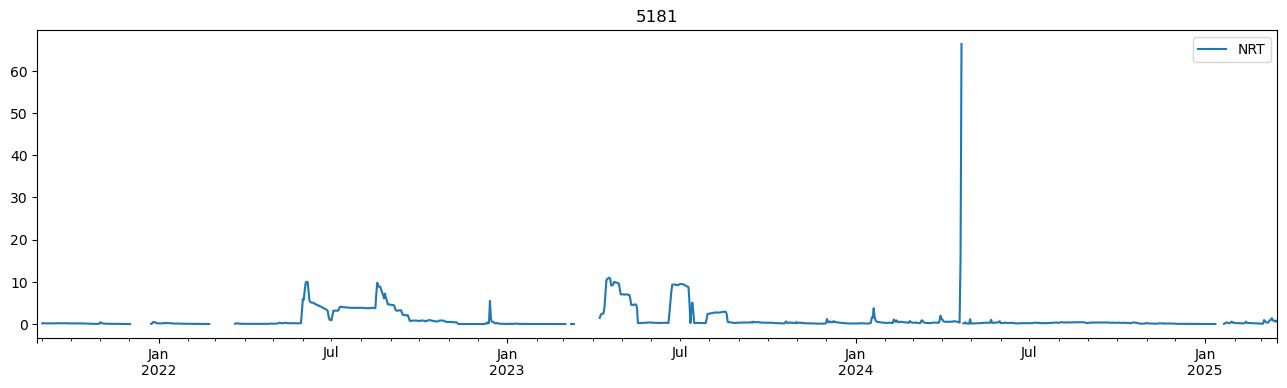

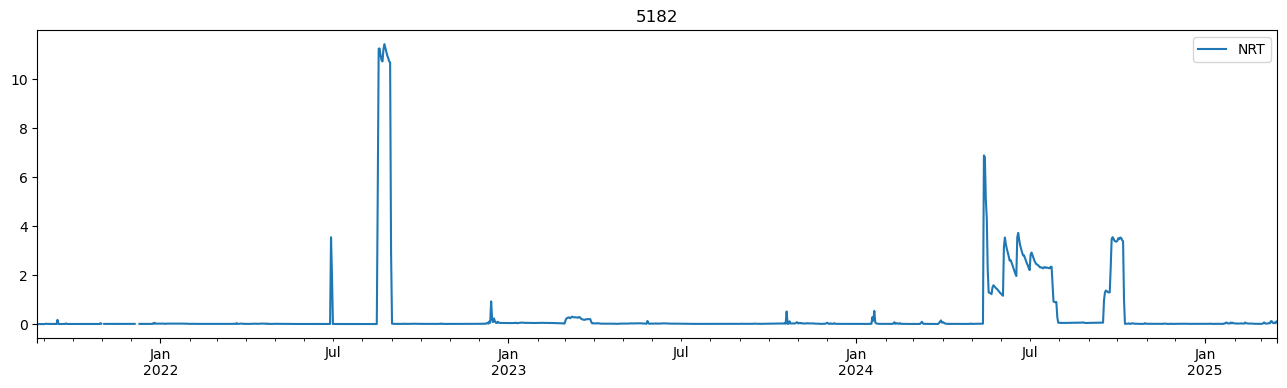

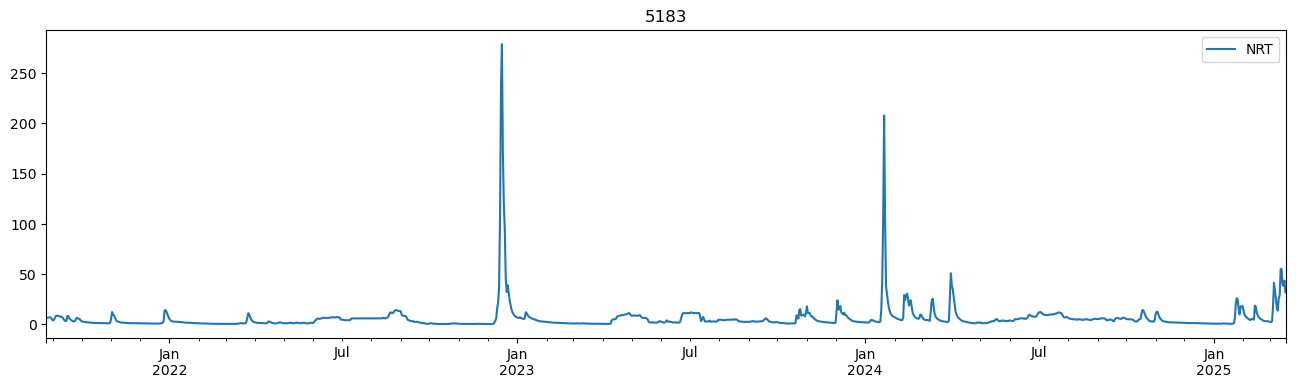

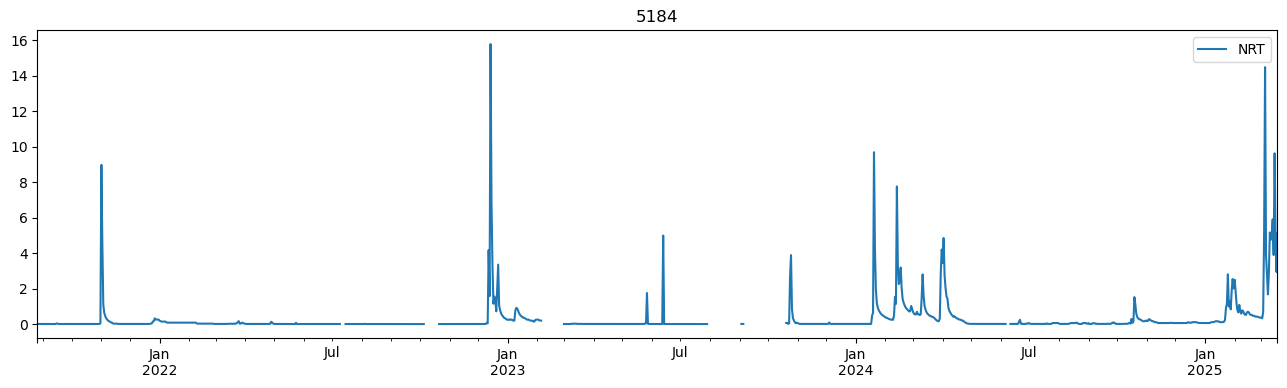

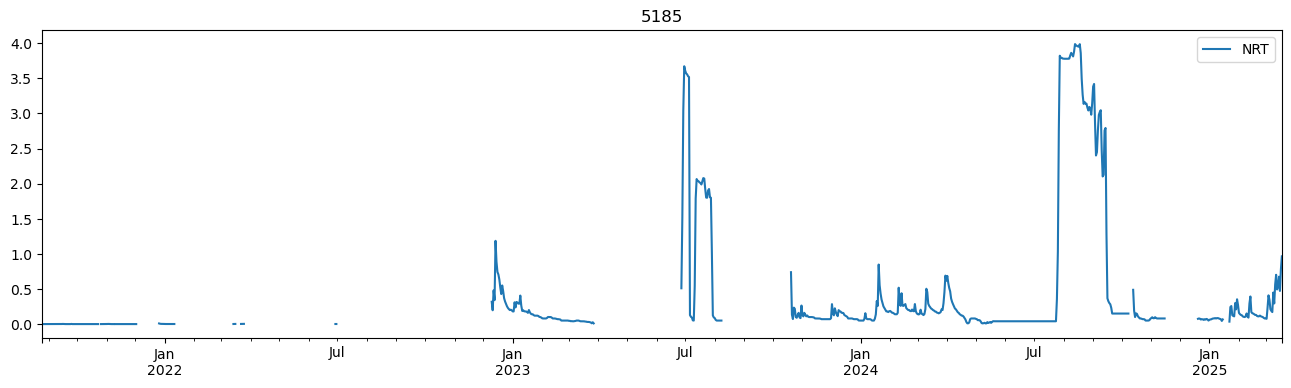

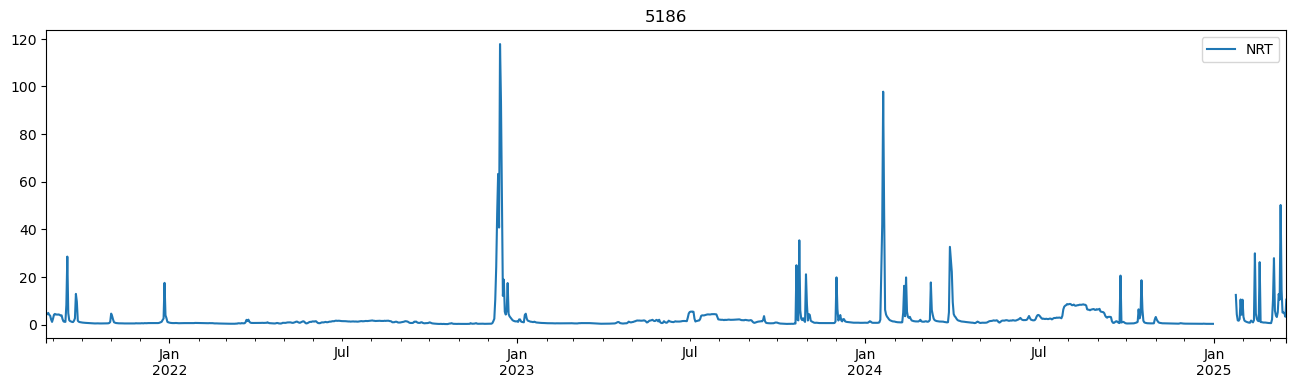

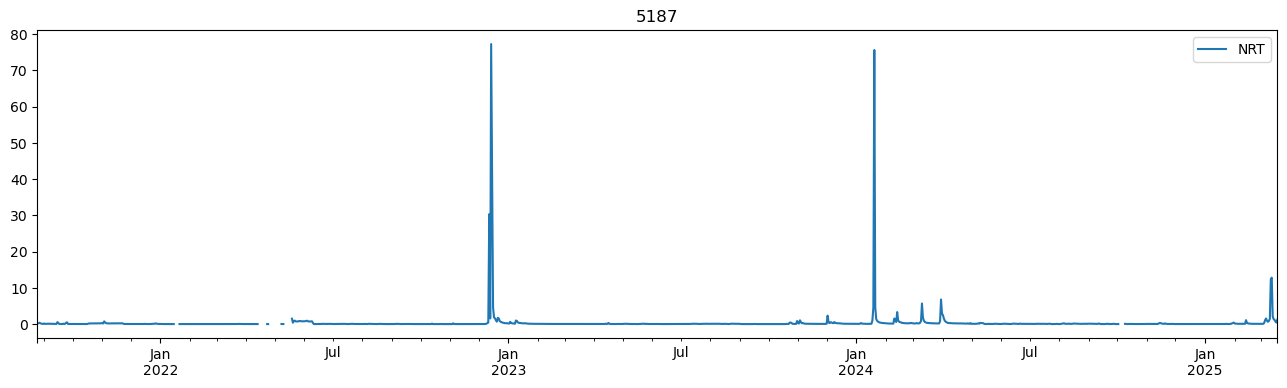

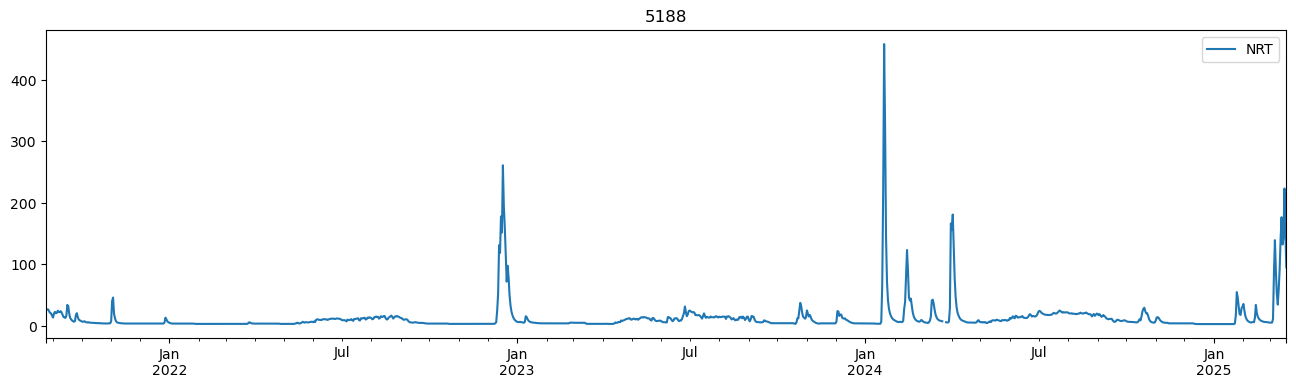

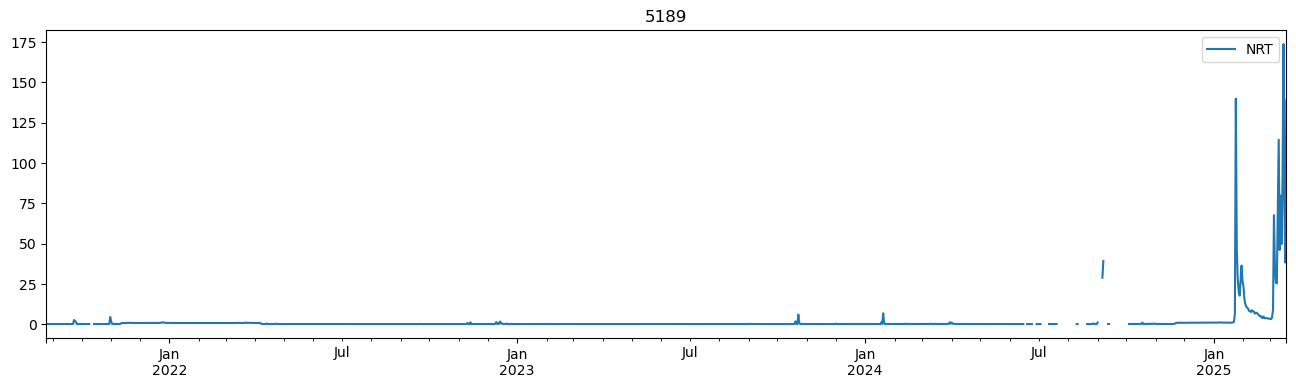

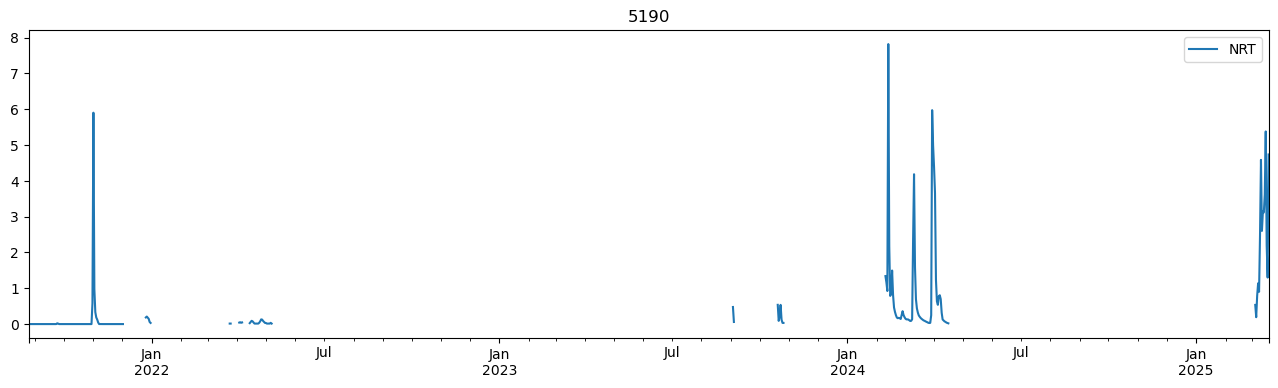

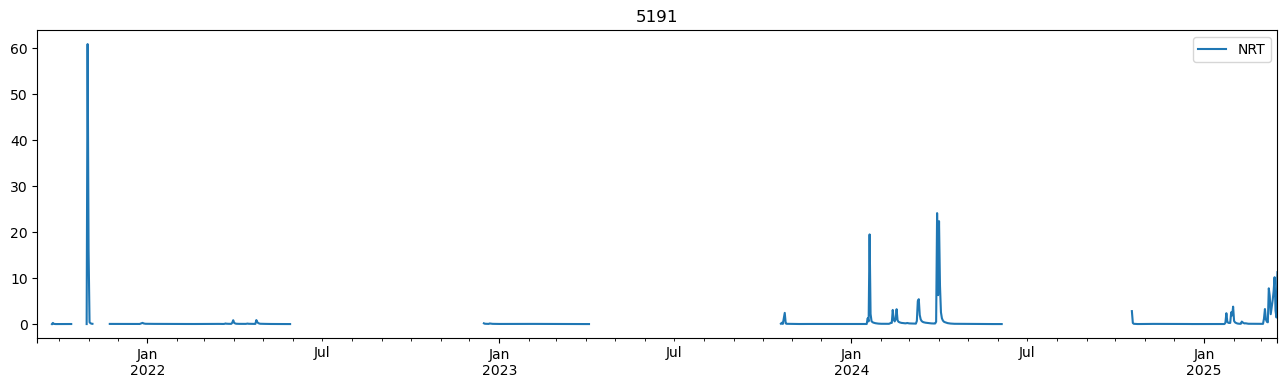

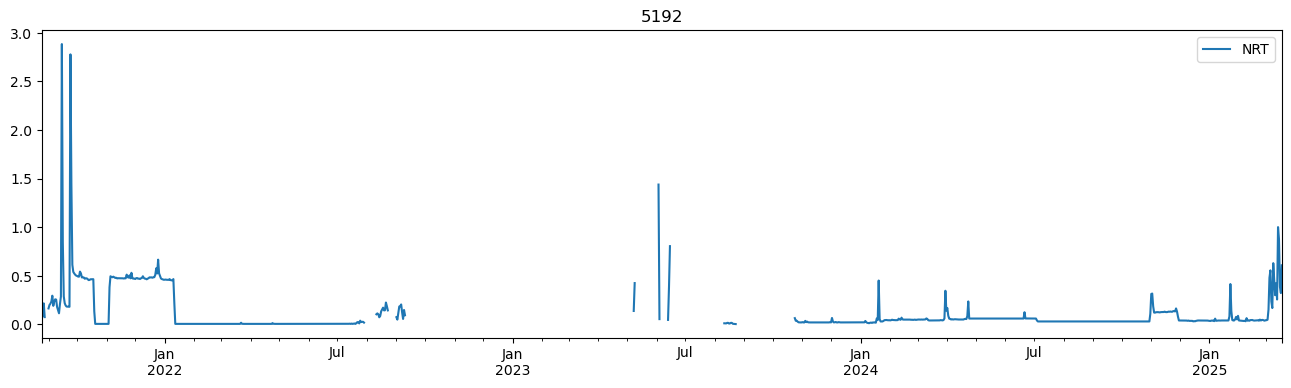

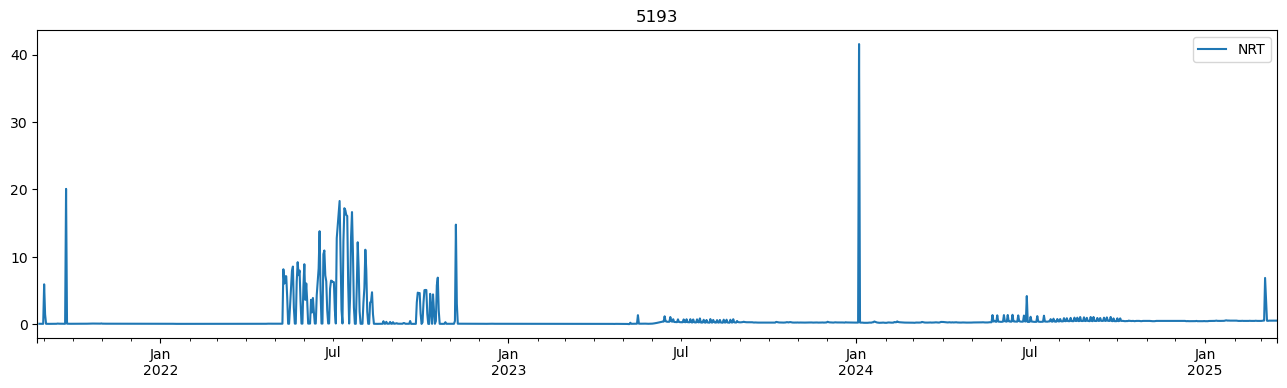

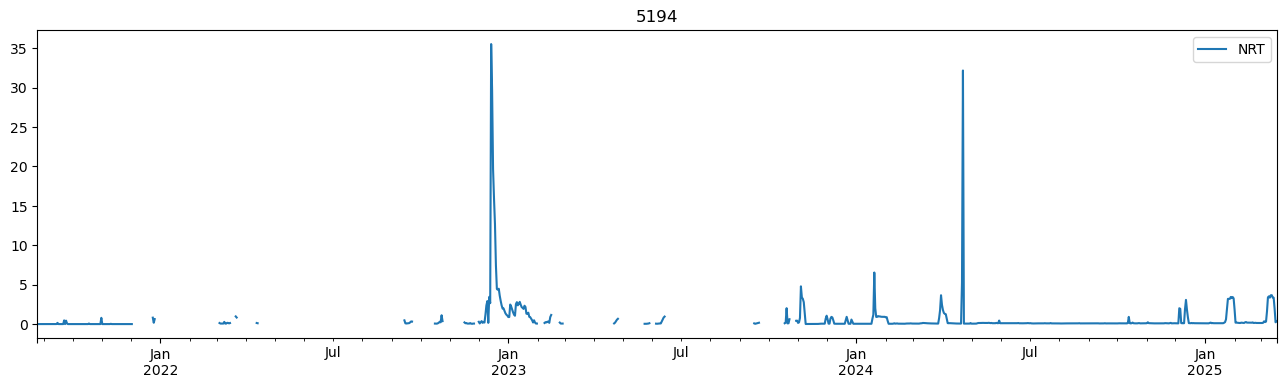

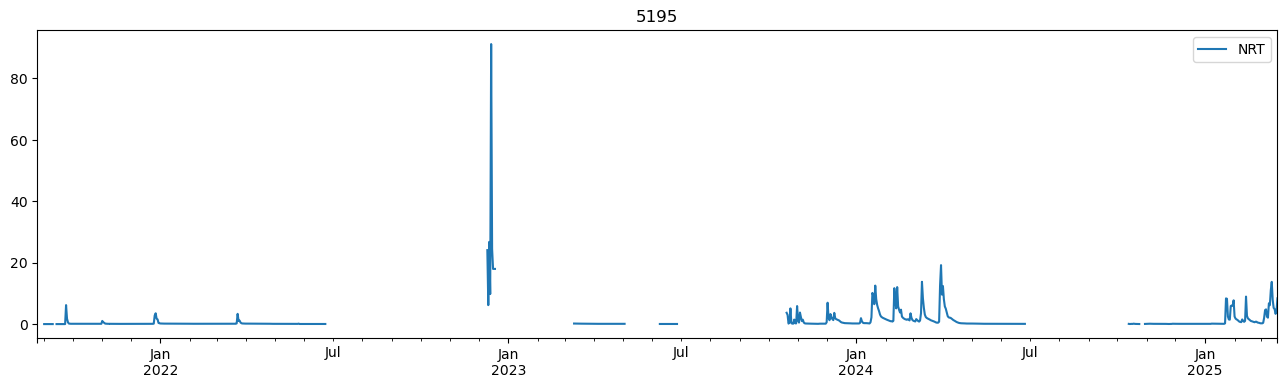

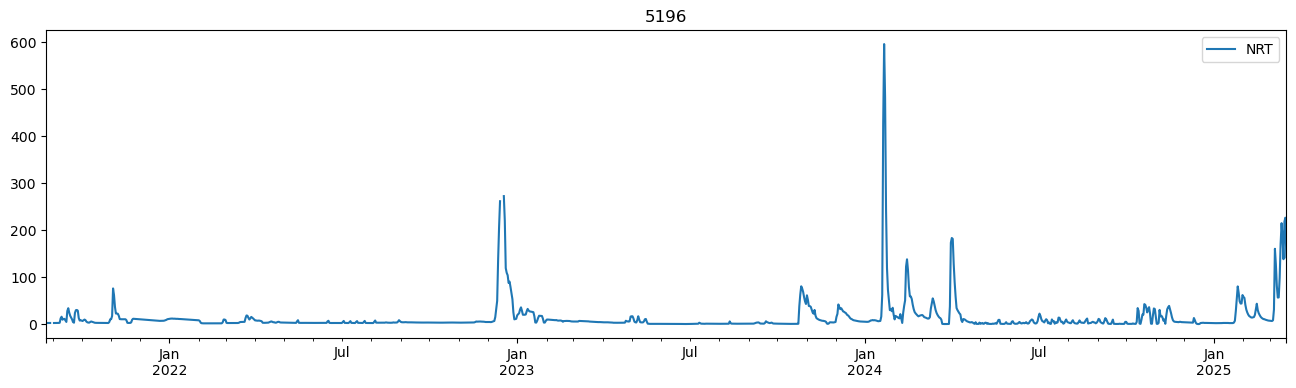

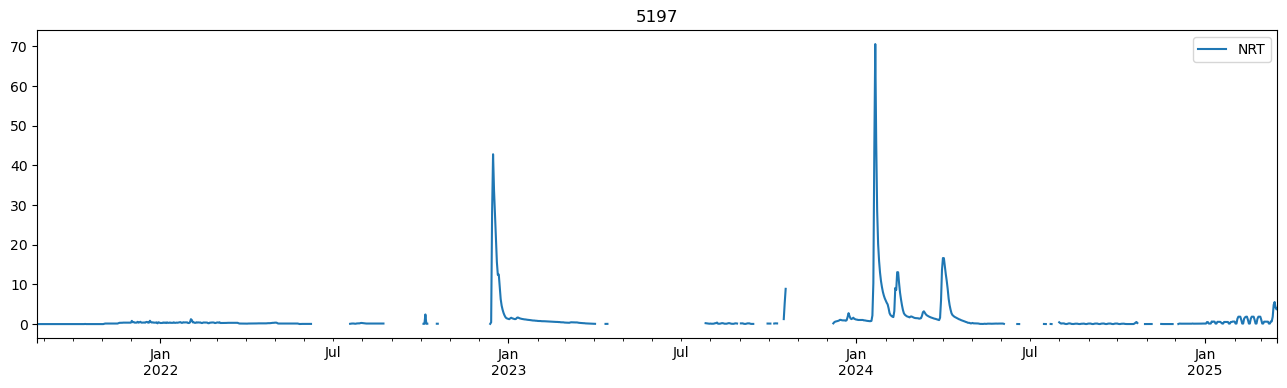

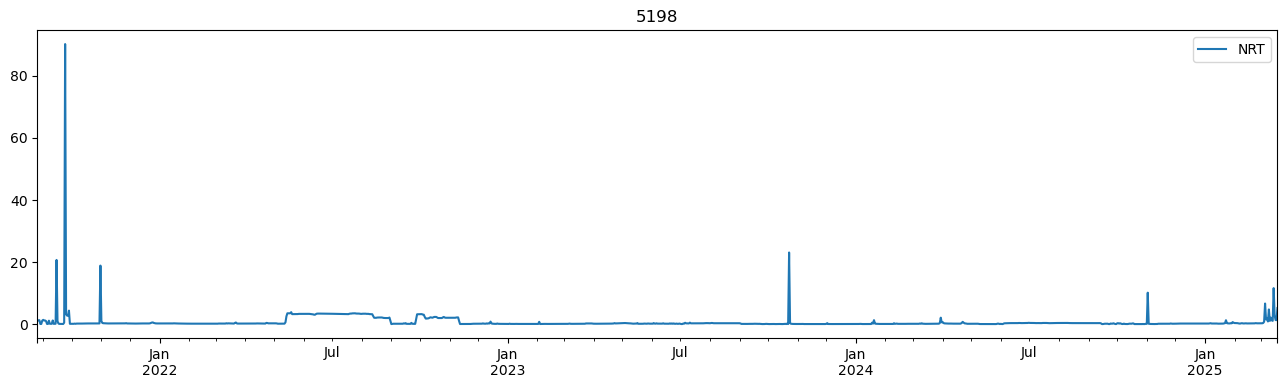

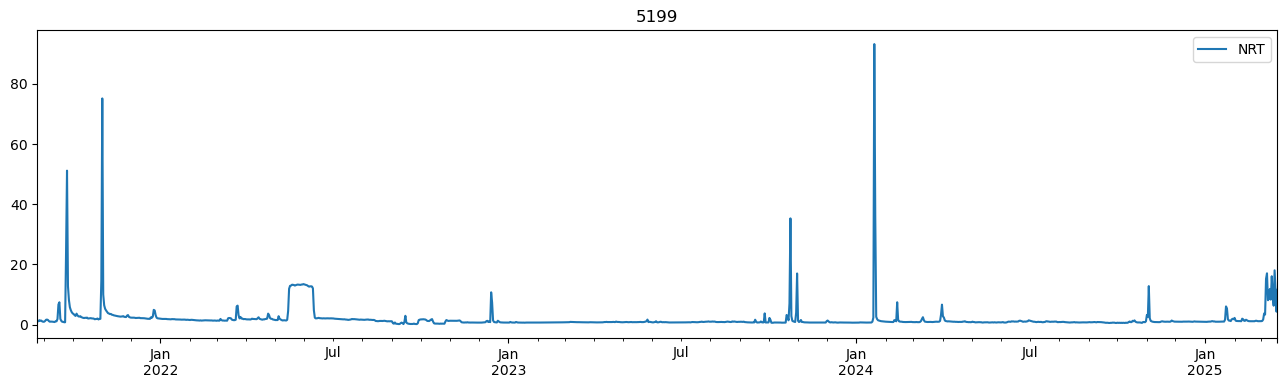

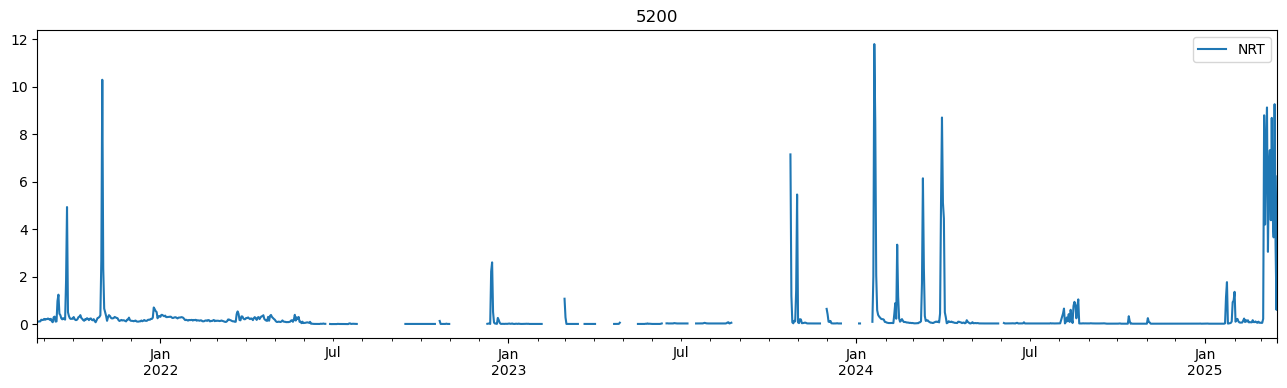

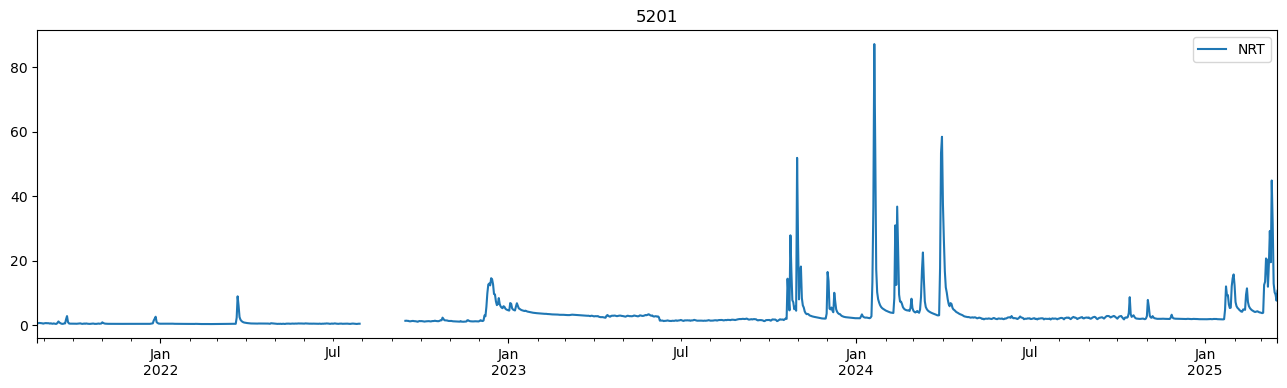

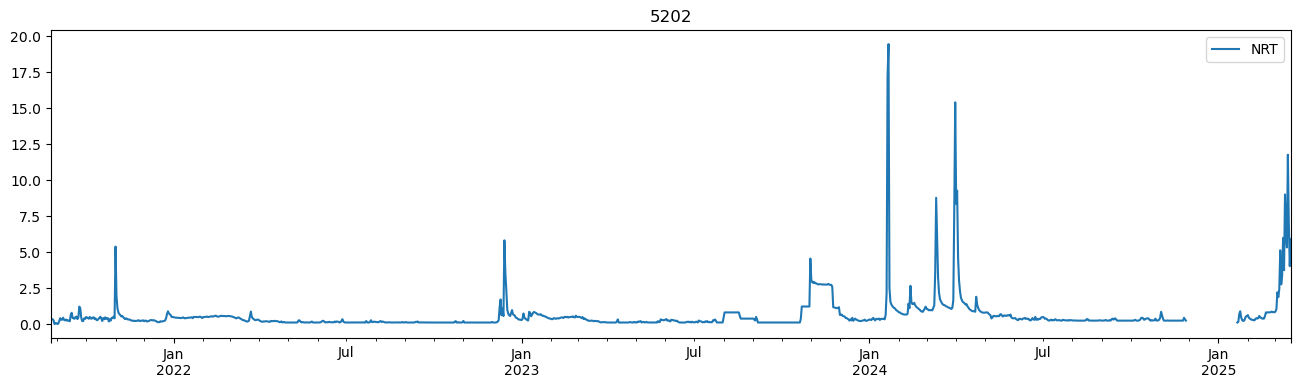

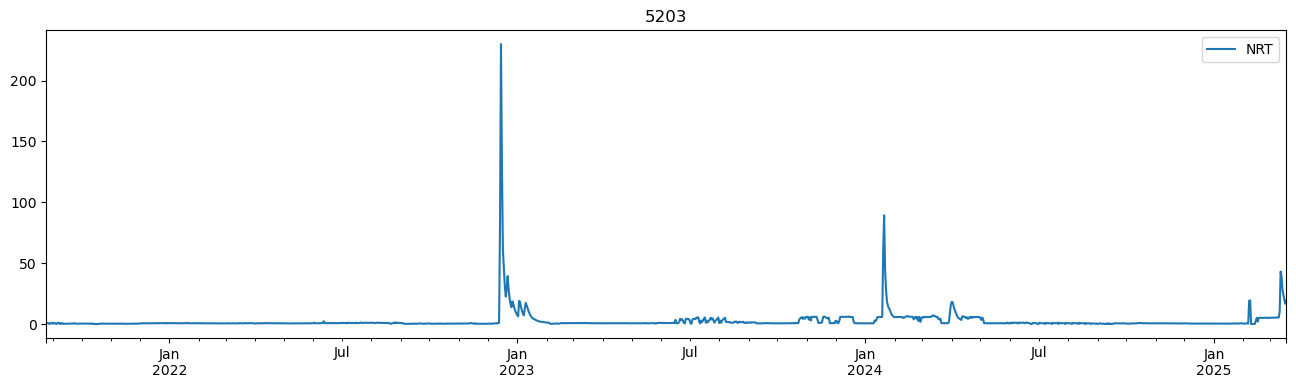

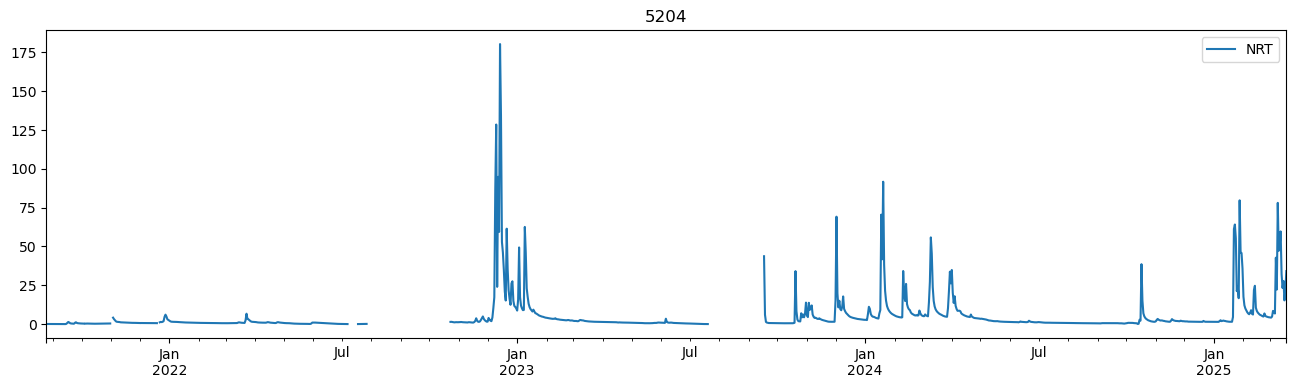

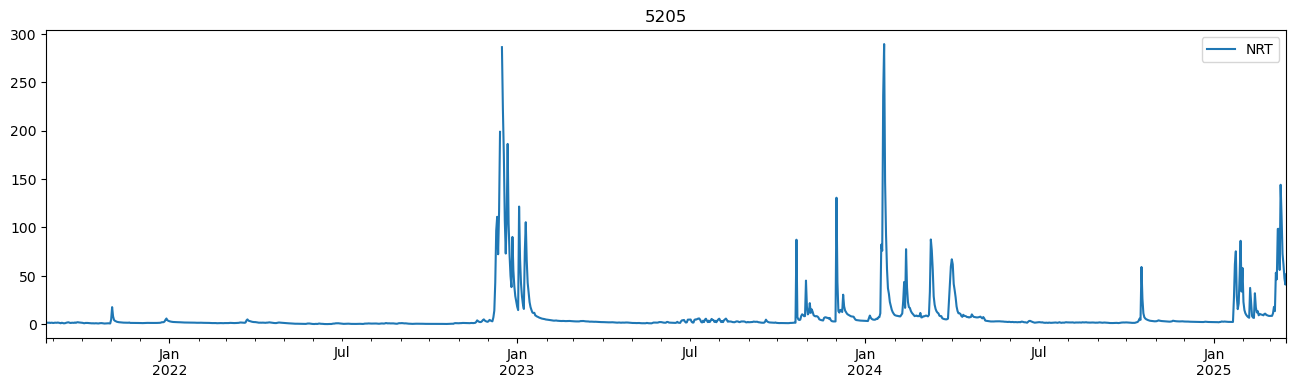

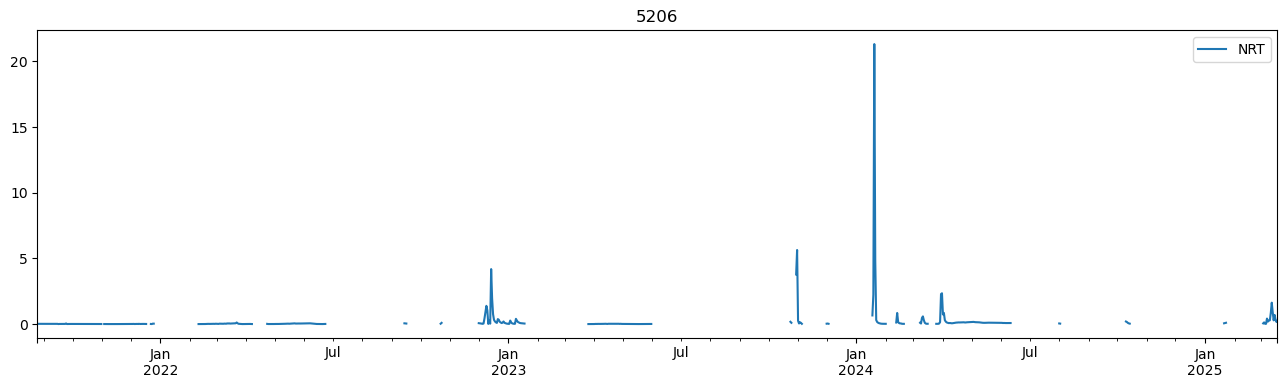

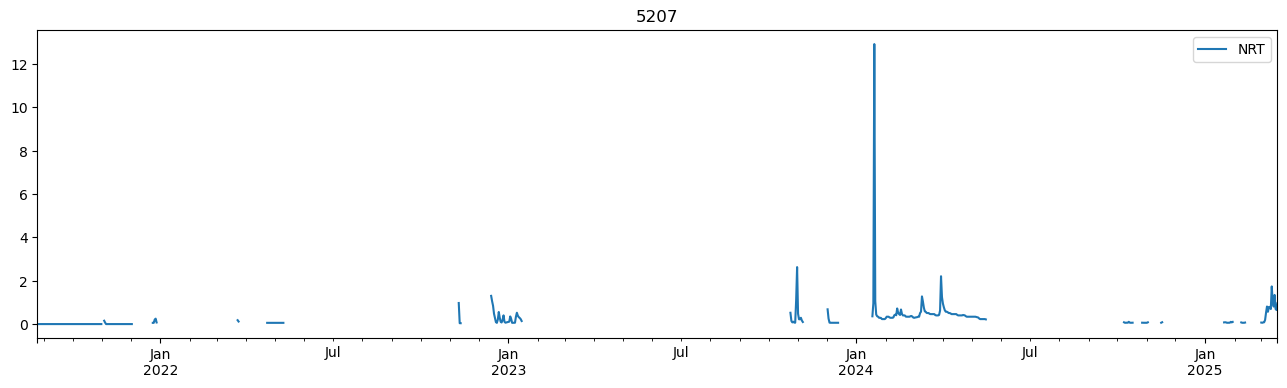

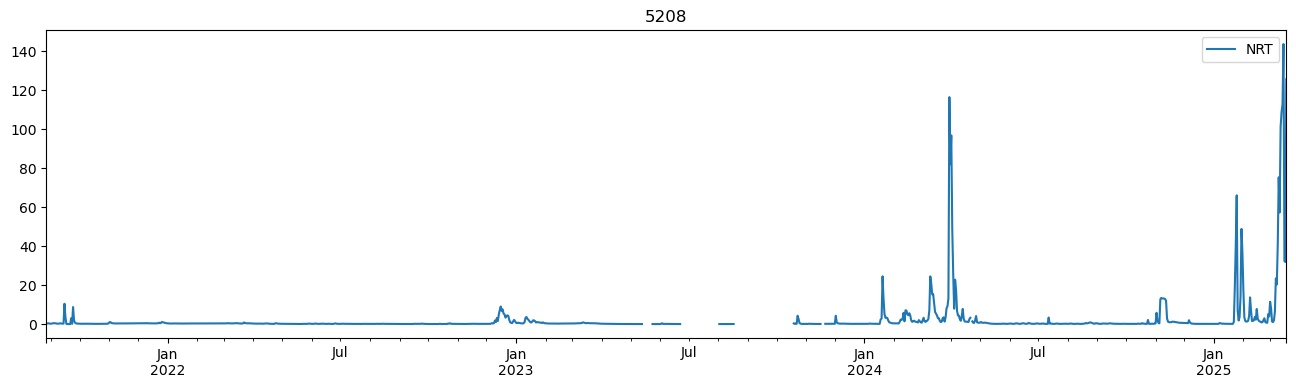

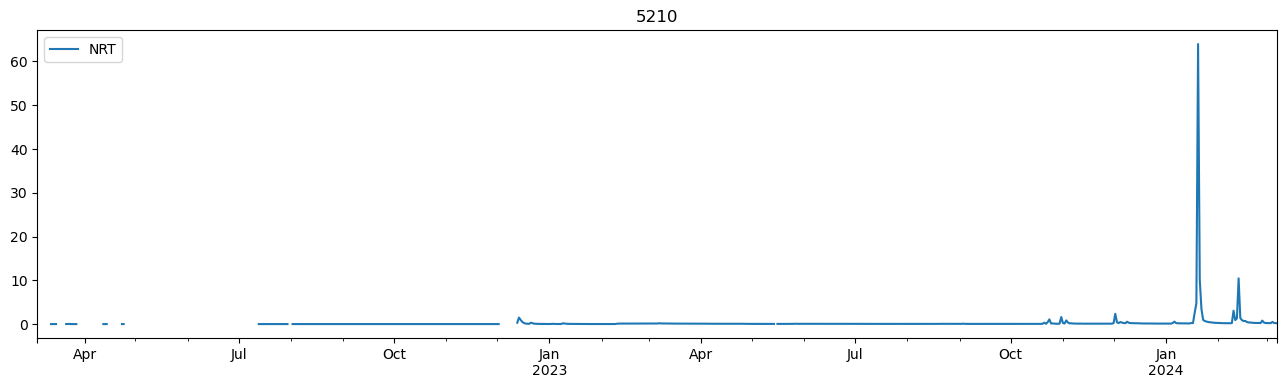

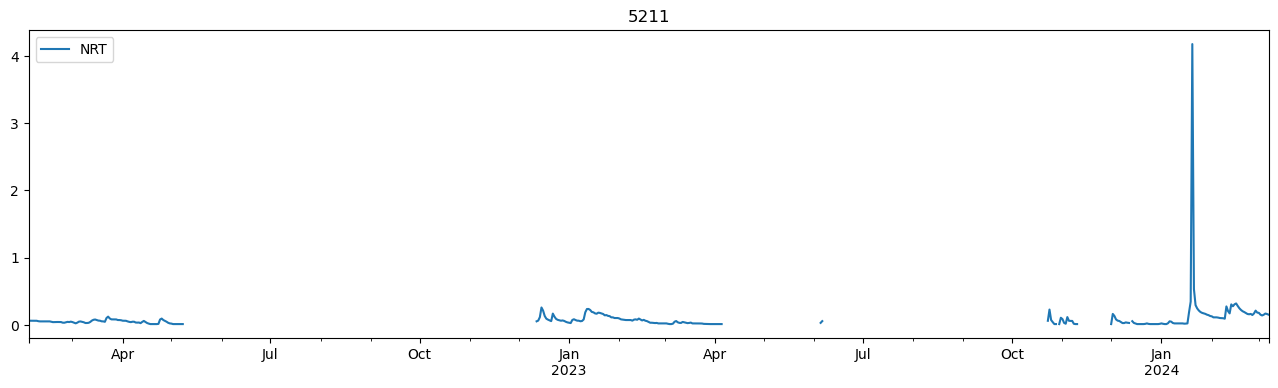

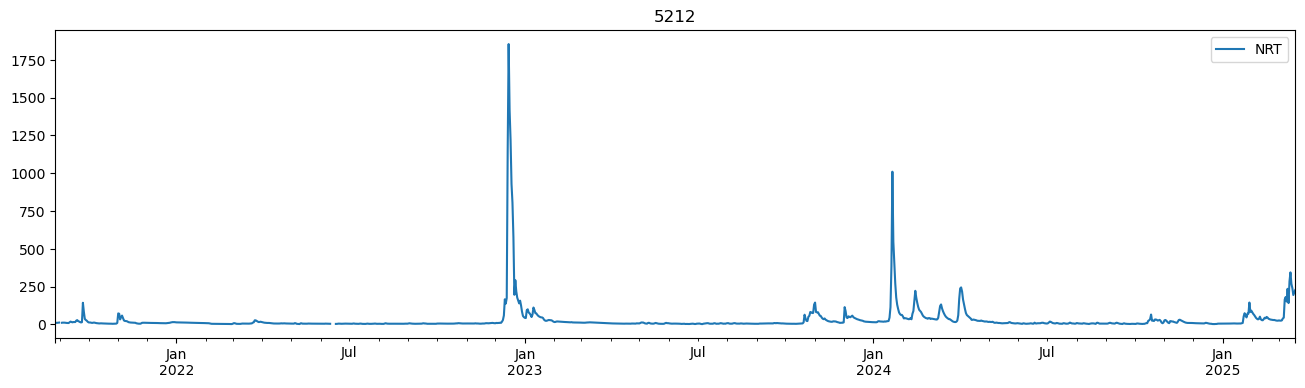

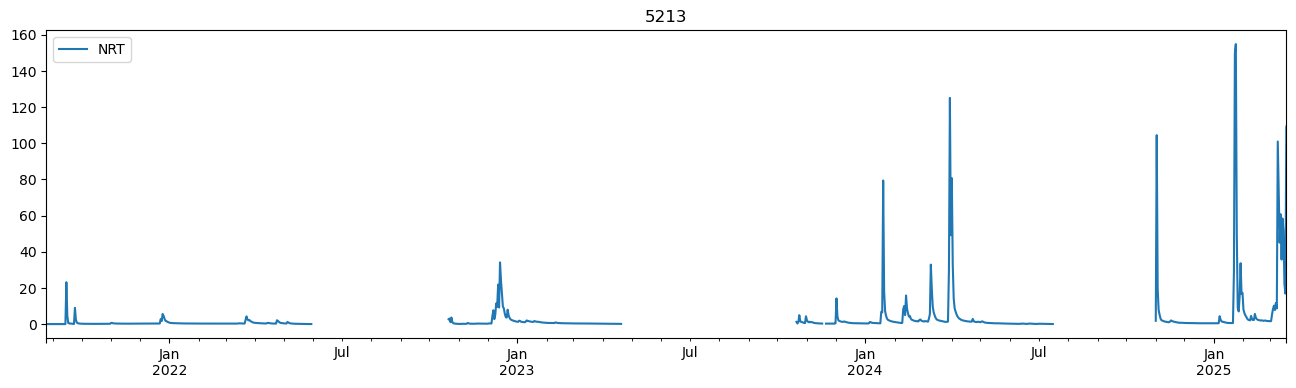

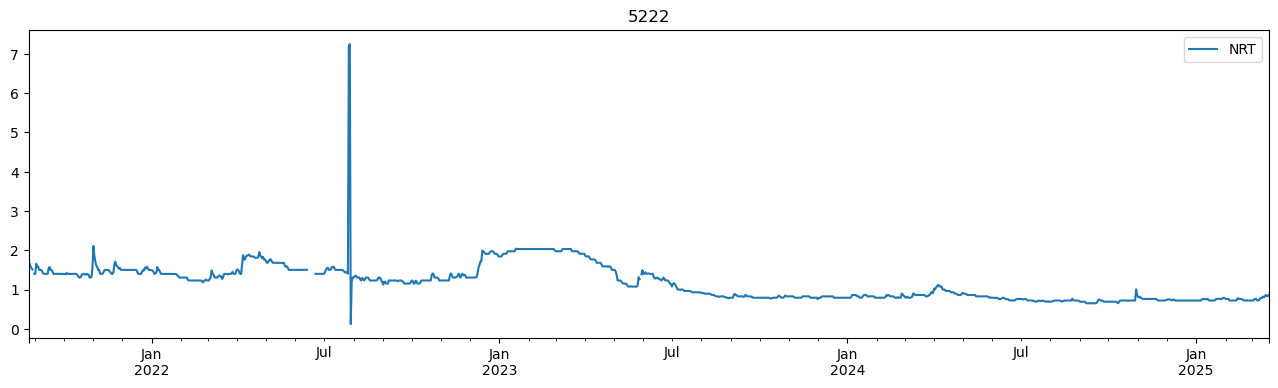

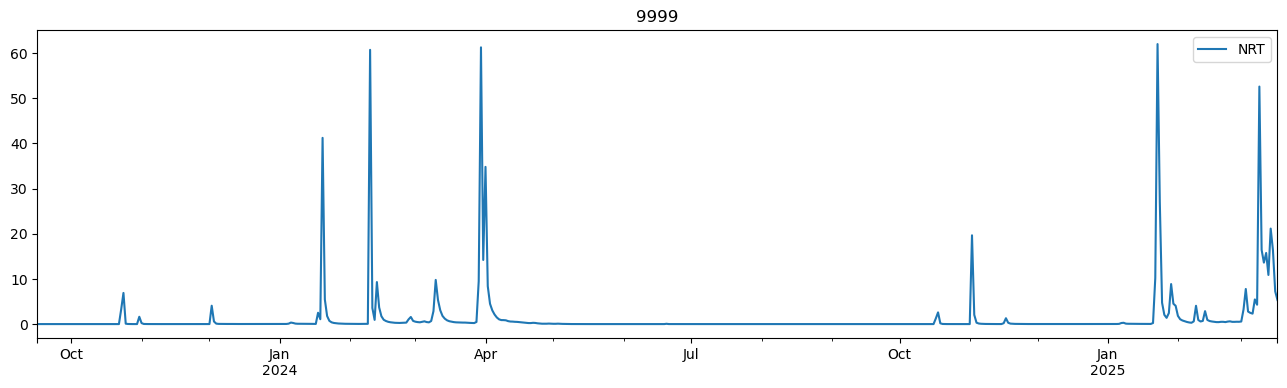

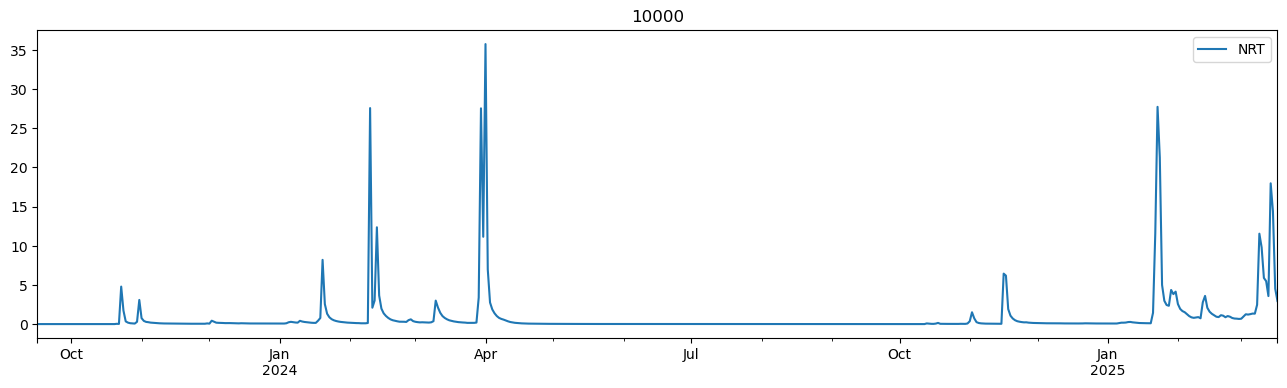

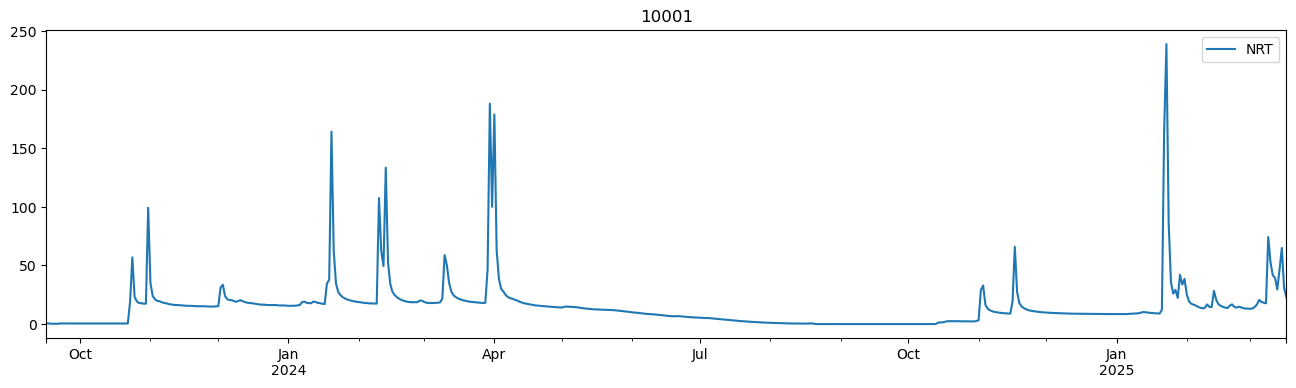

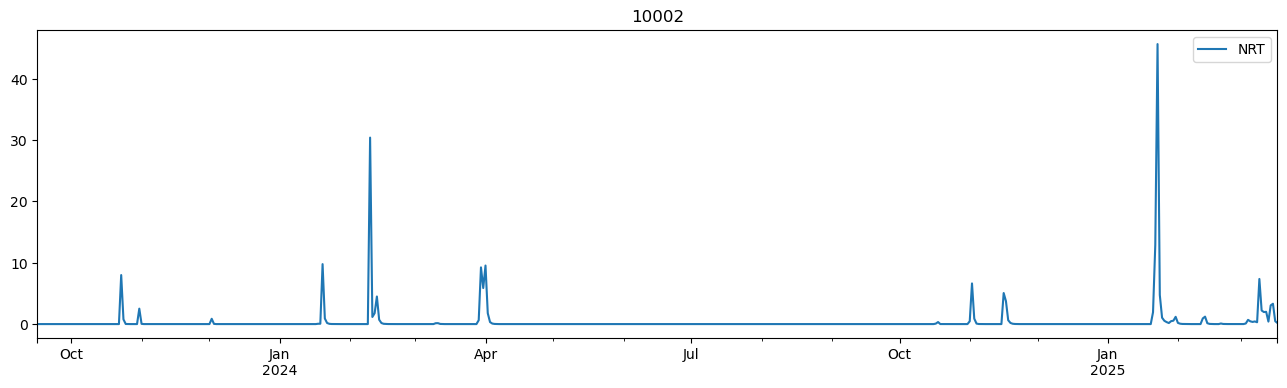

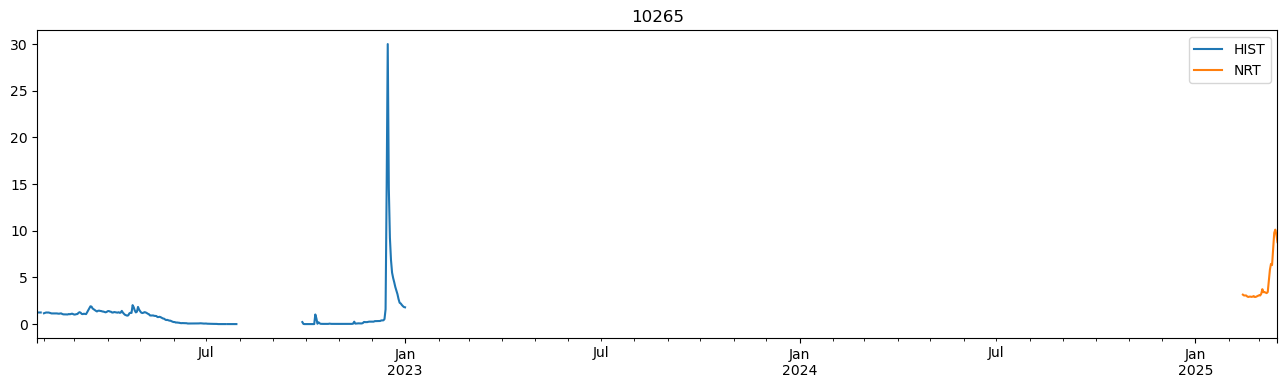

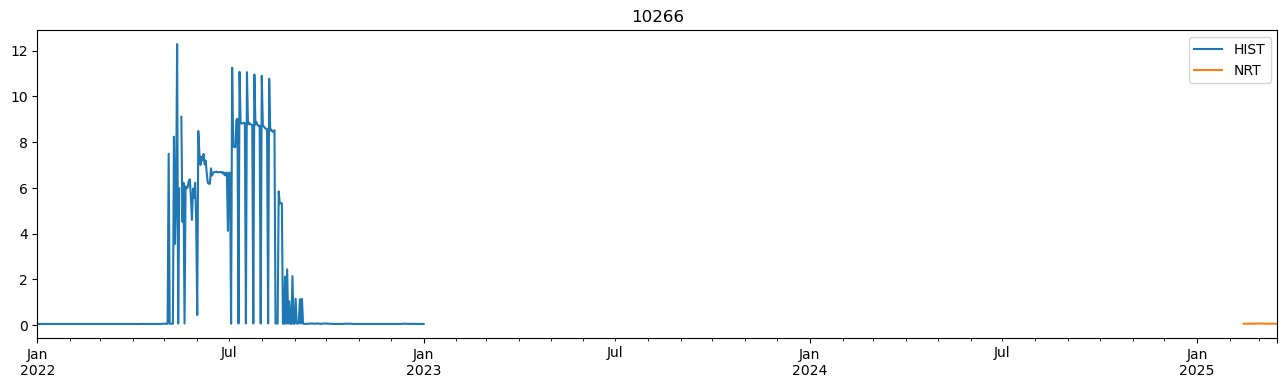

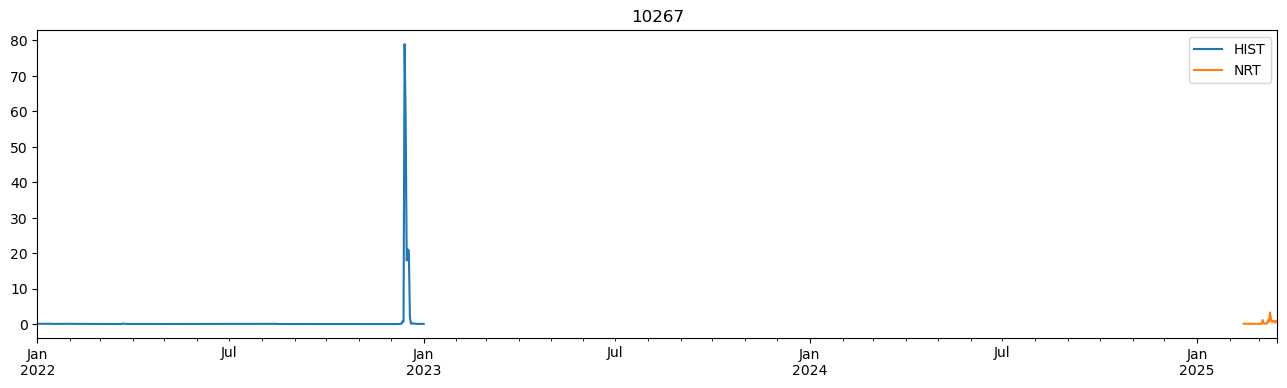

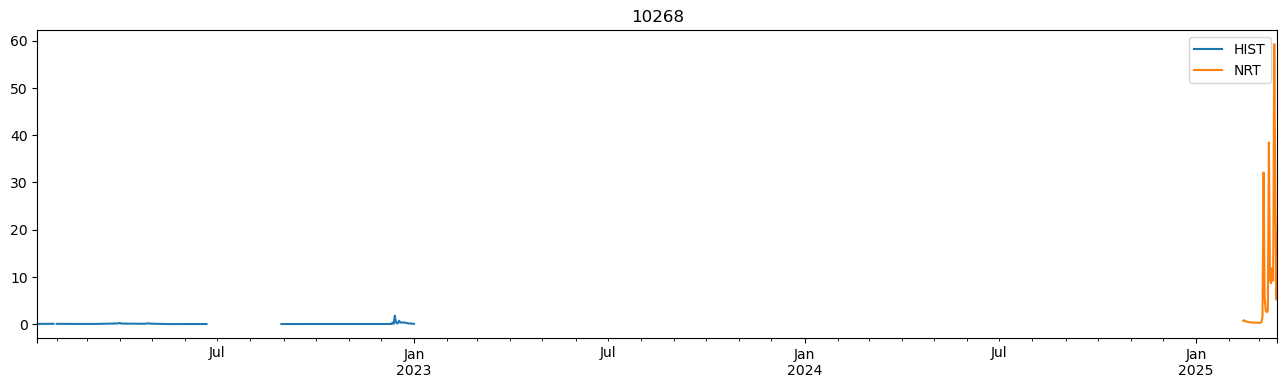

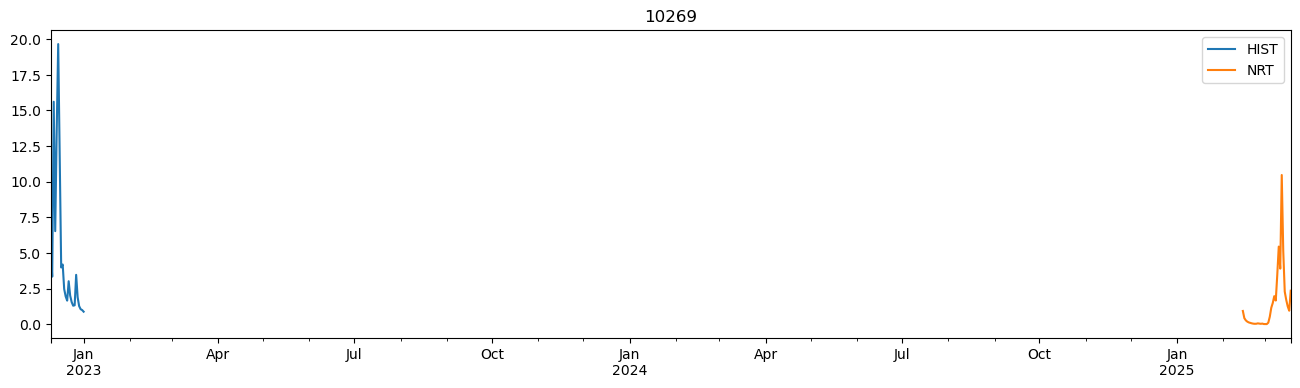

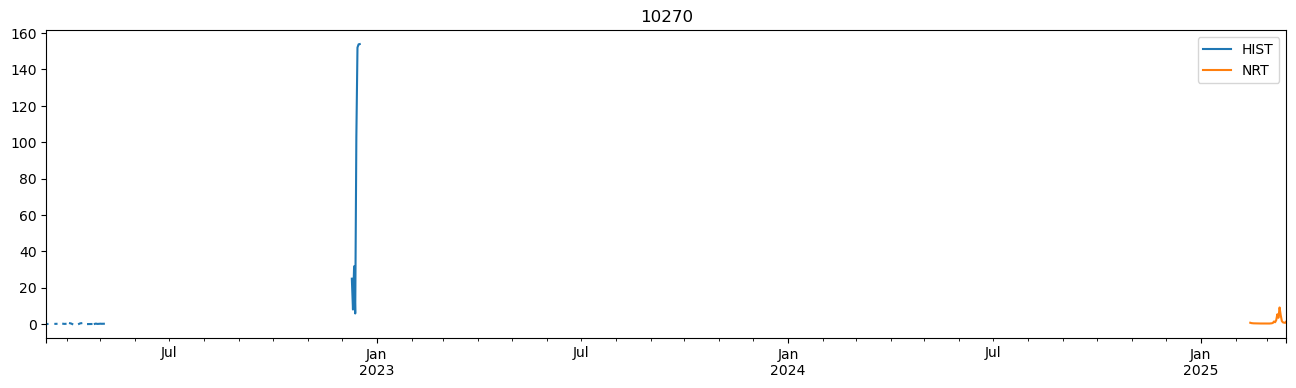

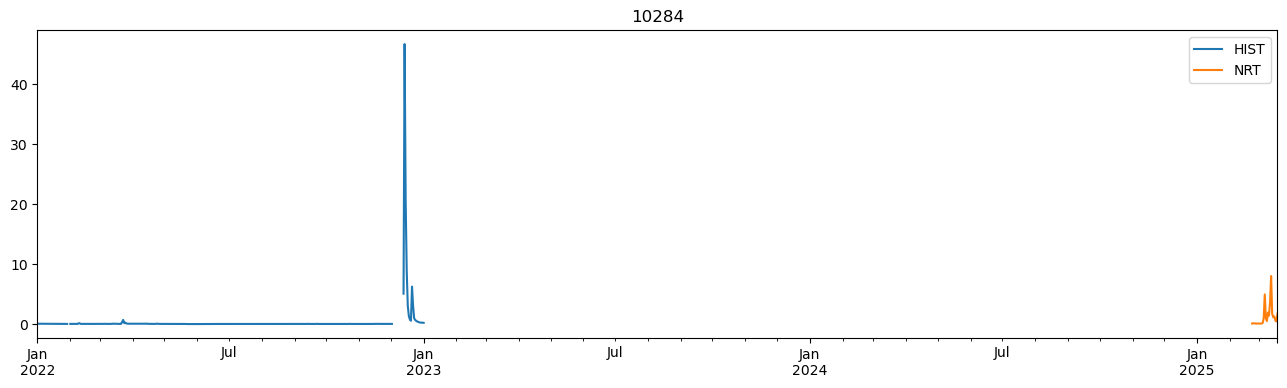

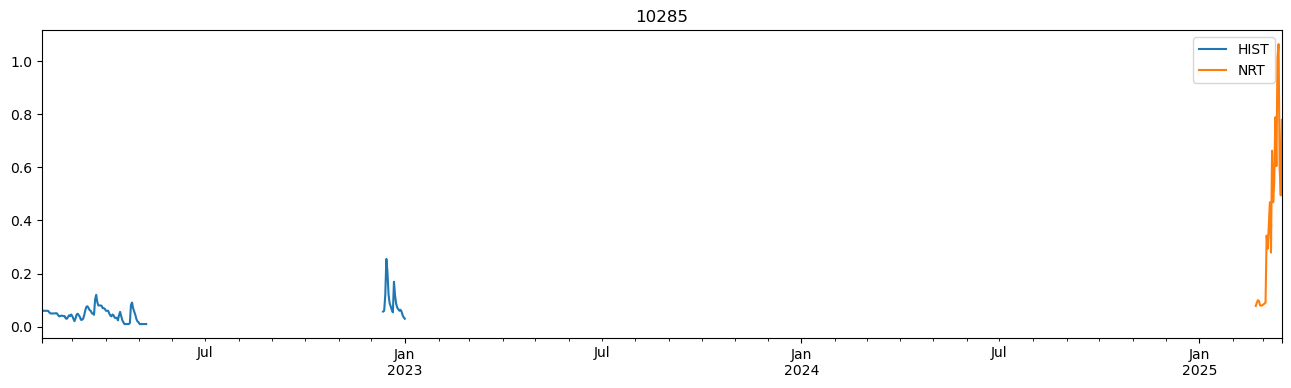

In [194]:
for efas_id, df in timeseries.items():
    if mask_duration[efas_id]:
        fig, ax = plt.subplots(figsize=(16, 4))
        df.plot(ax=ax)
        ax.set(title=efas_id)

In [200]:
# timeseries[2860]
timeseries[2859]

,HIST
1990-01-02,0.069
1990-01-03,0.069
1990-01-04,0.069
1990-01-05,0.069
1990-01-06,0.069
...,...
2010-09-27,0.0
2010-09-28,2.096
2010-09-29,4.191
2010-09-30,4.696


In [199]:
# timeseries[10266]
timeseries[5179]

,NRT
2021-08-25,0.753
2021-08-26,18.374
2021-08-27,3.278
2021-08-28,NaN
2021-08-29,25.688
...,...
2025-03-14,5.612
2025-03-15,4.375
2025-03-16,2.258
2025-03-17,1.992


## Maps

### Mask

In [109]:
# load map from GloFAS4
mask = xr.open_dataarray(PATH_TEST / 'GloFAS' / 'maps' / 'my_mask.nc')#.squeeze(dim='band').astype(int)
mask = mask.rename({'y': 'lat', 'x': 'lon'})
mask.close()

### Gauges

In [70]:
gauges = mask.copy()
gauges.name = 'gauges'

gauges = gauges.where(mask != 1, -9999)

# assign IDs
for ID, row in tqdm(stations.iterrows(), total=len(stations)):
    if ID != 1465:
        continue
    pixel = gauges.sel({'lon': row.LON, 'lat': row.LAT}, method='nearest')
    gauges.loc[{'lon': pixel.lon.item(), 'lat': pixel.lat.item()}] = ID

# modify attributes
gauges.attrs['contributors'] = 'Juliana Disperati <juliana.disperati@ext.ec.europa.eu>'
gauges.attrs['creator'] = 'Jesús Casado Rodríguez <jesus.casado-rodriguez@ec.europa.eu>'
gauges.attrs['creator_name'] = 'casadje'
gauges.attrs['history'] = ('Created {0}'.format(datetime.now().strftime("%a %b %e %H:%M:%S %Y")))
gauges.attrs['history_of_appended_files'] = ''
gauges.attrs['institution'] = 'Joint Research Centre - European Commission'
gauges.attrs['references'] = 'Hydrological Data Management Service'
gauges.attrs['long_name'] = 'gauges'

# # define coordinate reference system
# gauges = gauges.rio.write_crs('EPSG:4326')

# sort latitude in descending order
gauges = gauges.sortby('lat', ascending=False)

  0%|          | 0/104 [00:00<?, ?it/s]

C:\DEV\Anaconda3\envs\xr\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\DEV\Anaconda3\envs\xr\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


In [39]:
# # export NetCDF map
# out_file = PATH_TEST / 'GloFAS' / 'maps' / 'gauges_{0}.nc'.format(datetime.now().strftime('%Y%m%d'))
# # gauges.rio.to_raster(PATH_TEST / 'GloFAS' / 'maps' / 'gauges.nc'.format(datetime.now().strftime('%Y%m%d')))
# gauges.to_netcdf(out_file)
# print(f'Saved in {out_file}')

Saved in Z:\nahaUsers\casadje\Guadiana\GloFAS\maps\gauges_20250318.nc


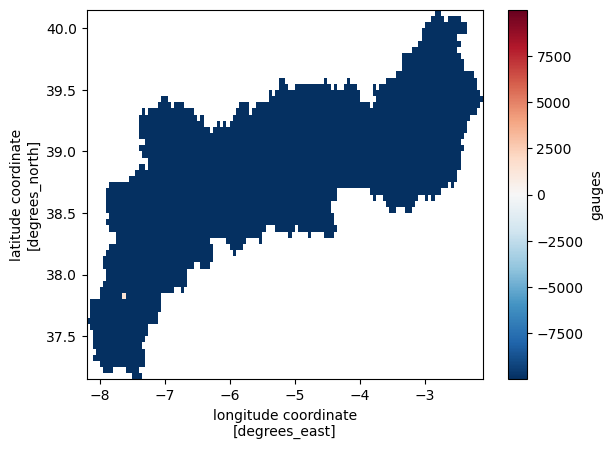

In [71]:
gauges.plot()

### Reservoirs

In [94]:
in_file = PATH_TEST / 'GloFAS' / 'maps' / 'reservoirs_glofas5_03min_20250307.nc'
reservoirs = xr.open_dataset(in_file)
reservoirs = reservoirs.rename({'Band1': 'reservoirs'})
reservoirs['lat'] = mask['lat']
reservoirs['lon'] = mask['lon']

In [95]:
# replace by -9999 pixels without reservoirs
reservoirs['reservoirs'] = reservoirs['reservoirs'].where(~((mask == 1) & reservoirs['reservoirs'].isnull()), -9999)

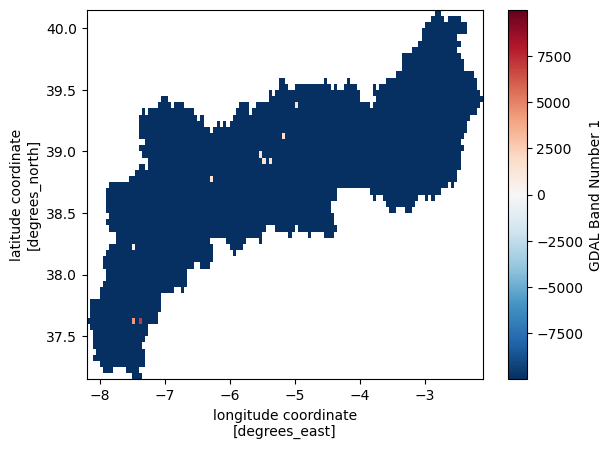

In [96]:
reservoirs['reservoirs'].plot();

In [101]:
# export NetCDF map
yyyymmdd = datetime.now().strftime('%Y%m%d')
if '_' in in_file.stem:
    filename = '_'.join(in_file.stem.split('_')[:-1])
else:
    filename = in_file.stem
out_file = f'{in_file.parent}/{filename}_{yyyymmdd}{in_file.suffix}'
reservoirs.to_netcdf(out_file)
print(f'Saved in {out_file}')

Saved in Z:\nahaUsers\casadje\Guadiana\GloFAS\maps/reservoirs_glofas5_03min_20250318.nc
